# Introduction to the TTT Algorithm and Its Implementation for Inferring Input Grammars of Blackbox Programs in Python

This tutorial will cover the introduction to the TTT algorithm and its implementation for inferring input grammars of blackbox programs in Python. The Python interpreter is embedded so that you can work through the implementation steps. In many previous posts, I have discussed how to parse with, fuzz with, and manipulate regular and context-free grammars. However, in many cases, such grammars may be unavailable. If you are given a blackbox program, where the program indicates in some way that the input was accepted or not, what can we do to learn the actual input specification of the blackbox? In such cases, the best option is to try and learn the input specification. This particular research field which investigates how to learn the input specification of blackbox programs is called blackbox grammar inference. In this tutorial we’ll discuss how the L* algorithm works, what are the inefficiencies in an algorithm and how TTT helps in overcoming them.
The TTT algorithm, a novel approach introduced by Malte Isberner, Falk Howar, and Bernhard Steffen in 2014. TTT addresses limitations of Angluin’s L* algorithm by eliminating redundant information, achieving optimal space complexity, and excelling in scenarios with complex systems.
## What is Active Automata Learning?
Active automata learning involves constructing a DFA that represents a system’s behavior by querying it. The learner operates in the Minimally Adequate Teacher (MAT) framework. The teacher is "minimally adequate" because it provides just enough information for the learner to infer the correct DFA. The goal is to minimize the number of queries while constructing an accurate model. Algorithms like L* and TTT operate within this framework, differing in how they process queries and counterexamples to build the DFA.
The goal is to build a DFA that accepts the same language as the system with minimal queries. L* The seminal algorithm in this field uses an observation table to store query results, but its quadratic space complexity and redundant processing of counterexamples can be problematic. TTT overcomes these issues with a tree-based approach and clever counterexample analysis.
## Comparison with L*
L*, the seminal algorithm in this field, uses an observation table to store query results, but its quadratic space complexity and redundant processing of counterexamples can be problematic. TTT overcomes these issues with a tree-based approach and clever counterexample analysis.
| Feature | L* Algorithm | TTT Algorithm |
|---------|-------------|---------------|
| Data Structure | Observation Table | Discrimination Tree |
| Space Complexity | O(n²) | O(n) |
| Counterexample Processing | Table reconstruction | Direct tree updates |
| Redundancy | High | Minimal |
## Symbols
-  **Q** → Set of all finite states
-  **Σ (Sigma)** → Input alphabet (set of allowed symbols).
-  **δ (Delta)** → Transition function, which determines movement between states.
-  **q₀** → Start state (initial state).
-  **F** → Set of final (accepting) states. Multiple final states are possible.
-  **F ⊆ Q** → Final states are a subset of total states.
## Key Definitions
To understand the TTT algorithm and its advantages, here are definitions of key terms used in this article:
-  **Membership Query (MQ)**: A query in the MAT framework where the learner asks the teacher whether a specific word w ∈ Σ* is accepted by the target DFA, receiving a boolean response (true if w is accepted, false otherwise).
-  **Equivalence Query (EQ)**: A query in the MAT framework where the learner proposes a hypothesis DFA and asks the teacher if it is equivalent to the target DFA. If not, the teacher provides a counterexample `a` word w where the hypothesis and target DFA produce different outputs.
-  **Counterexample**: A word w ∈ Σ* provided by the teacher in response to an equivalence query, where the hypothesis DFA H and the target DFA A disagree, i.e., λ<sub>H</sub>(w) ≠ λ<sub>A</sub>(w), where λ denotes the acceptance function.
-  **Discrimination Tree (DT)**: A binary tree used by TTT to organize state-distinguishing information. Inner nodes are labeled with discriminators (words that distinguish states by producing different outputs), and leaves represent states in the hypothesis DFA.
-  **RS Decomposition**: A technique used by TTT to process counterexamples by decomposing them into a prefix u, a single action a, and a suffix v such that u and u . a lead to different states in the target DFA but the same state in the hypothesis, with v revealing the discrepancy.
-  **Discriminator Finalization**: A process in TTT where temporary discriminators (added during counterexample processing) are replaced with shorter, final discriminators to eliminate redundancy and reduce the length of future queries.
-  **Canonical DFA**: A DFA A is canonical (i.e., minimal) if:
	-  **Reachability**: For all states q<sub>A</sub>, there exists a word u ∈ Σ* such that A[u] = q i.e., all states are reachable from the initial state.
	-  **Separability**: For all distinct states q ≠ q' ∈ q<sub>A</sub>, there exists a word v ∈ Σ* such that λ<sub>A</sub>(q, v) ≠ λ<sub>A</sub>(q', v) (i.e., all states are pairwisely separable, and v is called a separator). It is well-known that canonical DFAs are unique up to isomorphism.
## Setup

In [ ]:
from __future__ import annotations
from collections import deque
from copy import deepcopy

from IPython.display import Markdown, display # For text formatting
import plotly.graph_objects as go # For interactive visualizations
from graphviz import Digraph

In [353]:
EMPTYSET = "\u2205"
EPSILON = "\u03b5"
ALPHABET = "ab"
EXTENDED_ALPHABET = f"ab{EPSILON}"

Before we can learn a language, we need a way to represent it. In computer science, we use finite automata for this. Think of them as simple machines that read a string of characters one by one and, based on a set of rules, decide whether to accept or reject the string.

We'll start by building a foundational Automaton class in Python. This will be the blueprint for our more specific language machines.

## `Automaton` Class

Ever wanted to build your own little decision-making machine? Think of things like a vending machine that knows whether you've put in enough money, or a simple video game enemy that decides when to chase you. The `Automaton` class is your starting point for building things just like that!

Think of the **`Automaton` class as a blueprint**. It's not a finished machine itself, but it gives you the fundamental design and rules for building more specific types of machines, like a **DFA** (Deterministic Finite Automaton) or an **NFA** (Nondeterministic Finite Automaton).

### What's With the `Automaton[...]` Syntax?

You might see the class used like this: `Automaton[int, dict[str, set[int]]]`. This looks a bit like a generic type hint, and that's the whole idea!

This is a neat Python trick using a special method called `__class_getitem__`. It lets us "label" our blueprint to give hints about what kind of parts we'll be using. Let's break it down:

* `Automaton[...]`: We're using our automaton blueprint.
* `int`: This first part is a hint that we'll be using **integers** to name our states (e.g., State 0, State 1, State 2).
* `dict[str, set[int]]`: This second part describes our **rulebook** (the transitions). It's a hint that the rules will be a dictionary where you look up an input (`str`) and it tells you which new state(s) you can move to (`set[int]`).

This doesn't *change* how the class works, but it makes your code super readable and helps you remember what kind of data your specific machine is designed to handle.

In [354]:
class Automaton:
    # Allow subscription like Automaton[int, dict[str, set[int]]] without typing generics
    def __class_getitem__(cls, item):
        return cls

### The `add_state` Method:

Our `Automaton` blueprint knows that any machine built from it *must* have a way to add new states and their rules. However, the blueprint itself doesn't know the exact details. That's where the `add_state` method comes in.

This method is intentionally left empty. If you try to use it directly from the base `Automaton` class, it will raise a `NotImplementedError`.

**Why?** Because **you** have to define how adding a state works for the specific machine you're building! How you add a state to a simple DFA is different from how you might add one to a more complex NFA.

So, when you create your own class that inherits from `Automaton`, you'll need to write your own `add_state` method. This forces you to define the core logic of your machine, ensuring it's complete and does exactly what you want it to. It's the blueprint's way of saying, "Okay, here's the design... now it's your turn to do the building!"

In [355]:
class Automaton(Automaton):
    def add_state(self, transitions):
        """Add a state to the automaton with the given transitions.
        Args:
            transitions: The transitions for the state.
        Raises:
            NotImplementedError: This method is not implemented.
        """
        raise NotImplementedError

To put it simply, the `make_final` method is how you tell your program which states are the "finish lines."

It takes a **state** and marks it as an **accepting state**. This means if your automaton ends its journey in one of these marked states, the input it was processing is considered valid or "accepted." It's like putting a "Finish" flag on certain squares in a board game—landing on one means you've won!

In [356]:
class Automaton(Automaton):
    def make_final(self, state):
        """Mark a state as final.

        Args:
            state: The state to be marked as final. Should be one of the
                automaton's states.
        """
        assert state in self.states
        self.final.add(state)

The `update` method lets you **change the rules** for a specific state in your automaton.

Think of it like this: your automaton is a map and each state is a city. The `transitions` are the roads leading out of that city. The `update` method allows you to **re-draw the roads** from a city without having to build a new one. You provide the name of the **`state`** (the city) and the new **`transitions`** (the new roads), and the method replaces the old roads with the new ones. This is useful for modifying how a state behaves without creating an entirely new state.

In [357]:
class Automaton(Automaton):
    def update(self, state, transitions):
        """Update the transitions for a given state.

        Args:
            state: The state for which transitions need to be updated.
            transitions: The new transitions for the state.
        """
        self.transitions[state] = transitions

The `evaluate` method checks if a given string is a valid "word" for your automaton.

It takes an input **string** `s` and a boolean value is returned: `True` if the string is **accepted**, and `False` if it's not. The method starts at the **start state** and processes the string one character at a time. It follows the transitions based on each character. For a DFA, this is straightforward as there is only one path to follow. For an NFA, it's a bit more complex since it might need to keep track of multiple possible paths simultaneously. After processing the entire string, the method checks if the automaton has landed in one of the designated **final states**. If it has, the string is accepted and `True` is returned; otherwise, it's rejected, and `False` is returned.

In [358]:
class Automaton(Automaton):
    def evaluate(self, s):
        raise NotImplementedError

Our first machine is a Nondeterministic Finite Automaton (NFA). It's "nondeterministic" because from a given state, there might be multiple possible next steps for a single input character. It can even have "epsilon" transitions, which are like free moves it can take without reading any input. This flexibility is great for building automata from regular expressions.

### NFA Class Description
The `NFA` class is a concrete implementation of the `Automaton` protocol, specialized for Nondeterministic Finite Automata. It handles integer states (`T=int`) and transition tables that map input symbols to a set of possible next states (`S=dict[str, set[int]]`). The class provides methods for constructing, manipulating, and evaluating NFAs, including converting them to a DFA.

### Methods

##### `__init__(self) -> None`
Initializes a new `NFA` object.

- **Parameters**: None
- **Returns**: None
- **Behavior**: Sets up a new NFA with a single starting state (ID `0`), an empty set of final states, and an empty transition dictionary. The `next_state` counter is initialized to `1` to prepare for adding new states.

In [359]:
class NFA(Automaton[int, dict[str, set[int]]]):
    next_state: int

    def __init__(self) -> None:
        self.transitions = {}
        self.start = 0
        self.states = {self.start}
        self.final = set()
        self.next_state = 1

The `add_state` method adds a **new state** to your NFA, giving it a unique ID. You just provide the **transitions** for this new state as a dictionary. For example, a key 'a' with a value `{1, 2}` means that on input 'a', the automaton can move to either state 1 or state 2. The method assigns a new ID, stores your transitions, and then gets ready for the next new state by incrementing its internal counter.

In [360]:
class NFA(NFA):
    def add_state(self, transitions):
        display(Markdown(f"# Adding State\n## State: {self.next_state}\n## Transitions: {transitions}"))
        self.states.add(self.next_state)
        self.transitions[self.next_state] = transitions
        self.next_state += 1

The `evaluate` method checks if an input string is accepted by the NFA. It simulates the automaton's path through the string, keeping track of all possible current states at any given moment.

### How it Works

The process starts with a set containing only the **start state**. As the method reads each character of the input string, it calculates a new set of possible next states. This is done by looking at all transitions from all states in the current set for that specific character.

Since an NFA is **nondeterministic**, a single character can lead to multiple states from a single current state, which is why a set is needed to track all possibilities.

After the entire string has been processed, the method checks if the final set of possible current states contains at least one of the automaton's **final states**. If there's any overlap, it means there was at least one valid path from the start to a final state, so the method returns `True`. Otherwise, it returns `False`. 

In [361]:
class NFA(NFA):
    def evaluate(self, s):
        display(Markdown(f"## Evaluating NFA on input: `{s}`"))
        curr = {self.start}
        for c in s:
            curr = set().union(*(self.transitions[state].get(c, set()) for state in curr))
        return len(curr & self.final) > 0

The `insert` method is a key part that integrates a smaller NFA (`nfa`) into a larger one (`self`). The method's goal is to replace a single state in the main NFA with the entire sub-NFA, while maintaining a valid and functional automaton.

### 1. State ID Management

To prevent conflicts, the method re-maps the state IDs of the incoming NFA. It uses an **offset**, which is the current `next_state` count of the main NFA. For example, if the main NFA has states `0, 1, 2`, the offset is `3`. Any state `i` in the sub-NFA becomes `i + 3` in the main NFA.

### 2. Handling Final States

The method adjusts final states based on the insertion point (`state`) and the sub-NFA's behavior. If the sub-NFA accepts the **empty string** (its start state `0` is final), the original insertion state remains final. If it doesn't, the insertion state is no longer final. All final states from the sub-NFA are re-mapped with the offset and added to the main NFA's `final` set.

### 3. Merging Transitions

This is the most intricate part of the process. The transitions of the sub-NFA are updated to reflect their new, offset state IDs. The method then merges these new transitions with those of the main NFA.

* If the inserted NFA accepts the empty string, the main NFA's transitions from the insertion point are merged with the transitions from the sub-NFA's new start state.
* If the inserted NFA does not accept the empty string, the transitions from the sub-NFA's new start state **replace** the transitions of the original insertion point.
* Transitions from the sub-NFA's final states are merged with the transitions from the original insertion point, creating a loop-like connection that links the end of the sub-NFA back to the original path.

### 4. Finalizing the NFA

Finally, the new and old transitions are combined. The main NFA's `next_state` counter is updated to reflect the total number of states after the insertion, preparing the automaton for any further additions. 

In [362]:
class NFA(NFA):
    def insert(self, state: int, nfa: NFA) -> None:
        display(Markdown(f"# Inserting NFA\n## Into State: {state}\n## NFA States: {nfa.states}\n## NFA Transitions: {nfa.transitions}"))
        self.states |= set(range(self.next_state, self.next_state + nfa.next_state - 1))

        if state in self.final:
            display(Markdown(f"[DEBUG NFA.insert] State {state} is final, adjusting final states"))
            if 0 not in nfa.final:
                self.final.remove(state)
            self.final |= {s + self.next_state - 1 for s in nfa.final - {0}}

        nfa.transitions = {
            s: {
                char: set(map(lambda t: t + self.next_state - 1, targets))
                for char, targets in transitions.items()
            }
            for s, transitions in nfa.transitions.items()
        }

        new_transitions = {}
        for s in range(1, nfa.next_state):
            actual_state = s + self.next_state - 1
            if s in nfa.final:
                display(Markdown(f"[DEBUG NFA.insert] Merging transitions for final state {s} -> {actual_state}"))
                new_transitions[actual_state] = self.join_transitions(
                    nfa.transitions[s], self.transitions.get(state, {})
                )
            else:
                new_transitions[actual_state] = nfa.transitions[s]

        if 0 in nfa.final:
            display(Markdown(f"[DEBUG NFA.insert] Merging transitions for state 0 (final) into state {state}"))
            new_transitions[state] = self.join_transitions(
                nfa.transitions[0], self.transitions.get(state, {})
            )
        else:
            new_transitions[state] = nfa.transitions[0]

        print(f"[DEBUG NFA.insert] New transitions: {new_transitions}")
        self.transitions = {**self.transitions, **new_transitions}
        self.next_state += nfa.next_state - 1
        print(f"[DEBUG NFA.insert] Updated next_state: {self.next_state}")


The `join_transitions` method merges two transition dictionaries into a single one. It takes two dictionaries, `a` and `b`, and returns a new dictionary that combines their transitions.

### How it Works

The method works by iterating through every unique input symbol present in either dictionary `a` or `b`. For each symbol, it finds the set of states it transitions to in `a` and the set of states it transitions to in `b`. It then creates a new, combined set of states by taking the **union** of these two sets. This new set represents all possible destination states for that symbol from either of the original dictionaries.

This process ensures that if an input symbol triggers a transition in both dictionaries, the resulting merged dictionary will include all possible target states from both. If a symbol only exists in one dictionary, its transitions are simply carried over to the new, merged dictionary. 

In [363]:
class NFA(NFA):
    def join_transitions(
        self, a: dict[str, set[int]], b: dict[str, set[int]]
    ) -> dict[str, set[int]]:
        result = {char: a.get(char, set()) | b.get(char, set()) for char in a.keys() | b.keys()}
        display(Markdown(f"[DEBUG NFA.join_transitions] Result: {result}"))
        return result

The `remove_epsilon` method converts an NFA with **epsilon transitions** into an equivalent NFA that doesn't have them. It returns a new NFA object that recognizes the same language but is simpler because it only uses transitions based on actual input symbols.

### How it Works

The core of this process is calculating the **epsilon closure** for each state. The epsilon closure of a state is the set of all states you can reach from it by following one or more $\epsilon$ (epsilon) transitions.

The method then constructs a new NFA based on this information:

1.  **New Transitions**: For each state in the original NFA, it finds all states in its epsilon closure. From these states, it looks at all transitions triggered by an input symbol (not $\epsilon$). The new NFA's transition will go to the union of the epsilon closures of all these destination states. This ensures that the new automaton accounts for all possible paths that involved an epsilon transition.

2.  **New Final States**: A state in the new NFA is considered a **final state** if its corresponding epsilon closure in the original NFA contained at least one final state. This is because if a path could end at a final state through an epsilon transition, it must also be accepted in the new NFA. 

In [364]:
class NFA(NFA):
    def remove_epsilon(self) -> NFA:
        display(Markdown("#### Removing Epsilon Transitions"))
        nfa = NFA()
        nfa.transitions = {state: dict() for state in self.states}
        nfa.start = self.start
        nfa.states = self.states
        nfa.final = self.final
        nfa.next_state = self.next_state
        display(Markdown(f"[DEBUG NFA.remove_epsilon] Initialized new NFA: states={nfa.states}, final={nfa.final}"))

        for state in self.states:
            seen: set[int] = set()
            final = [False]

            def helper(curr: int) -> None:
                if curr not in seen:
                    seen.add(curr)
                    if curr in self.final:
                        final[0] = True
                    for a, targets in self.transitions.get(curr, {}).items():
                        if a == EPSILON:
                            for target in targets:
                                helper(target)
                        else:
                            nfa.transitions[state][a] = nfa.transitions[state].get(a, set()) | targets

            helper(state)
            if final[0]:
                print(f"[DEBUG NFA.remove_epsilon] Marking state {state} as final")
                nfa.final.add(state)
        nfa.trim_unreachable()
        print(f"[DEBUG NFA.remove_epsilon] states={nfa.states}, transitions={nfa.transitions}")
        return nfa

The `trim_unreachable` method optimizes an NFA by removing all states that cannot be reached from the starting state. It's a two-phase process that simplifies the automaton's structure without altering its accepted language.
### 1. Removing States Unreachable from the Start

This first phase uses a **Breadth-First Search (BFS)** to find all states that are directly or indirectly reachable from the NFA's start state. The algorithm begins at the `start` state and explores all connected states via any transition. All states discovered during this traversal are considered reachable. Any state in the NFA that was not visited during this BFS is marked as unreachable and is removed along with its associated transitions.
### 2. Removing Dangling States

This second phase is a cleanup to remove states that might be "dangling"—meaning they are reachable in theory but have no incoming transitions from other states that are part of the valid, reachable automaton. The method repeatedly checks every state (except the start state) to see if it has at least one incoming transition from a state that still exists. If a state has no such incoming transitions, it's removed. This process continues in a loop until a full pass is completed without removing any more states, ensuring that all dangling states are eliminated. 

In [365]:
class NFA(NFA):
    def trim_unreachable(self) -> None:
        seen = set()
        queue: deque[int] = deque([self.start])
        print(f"[DEBUG NFA.trim_unreachable] Starting BFS from state {self.start}")

        # The BFS loop continues as long as there are states to visit.
        while len(queue) > 0:
            # Get the next state from the front of the queue.
            curr = queue.popleft()
            # If the state has already been visited, skip it.
            if curr in seen:
                continue
            # Mark the current state as visited.
            seen.add(curr)
            print(f"[DEBUG NFA.trim_unreachable] Visited state {curr}")
            # Iterate through all transitions from the current state.
            for targets in self.transitions.get(curr, {}).values():
                # For each target state in the transition,
                for target in targets:
                    # if the target has not been seen yet, add it to the queue to be visited.
                    if target not in seen:
                        queue.append(target)

        # After the BFS, `seen` contains all states reachable from the start state.
        # The first loop identifies states that are completely unreachable from the start.
        # It finds all states that are in the NFA but not in the `seen` set.
        for state in list(self.states - seen):
            print(f"[DEBUG NFA.trim_unreachable] Removing unreachable state {state}")
            # Remove these states from the NFA's `states` set.
            self.states.remove(state)
            # Also remove their transitions from the `transitions` dictionary.
            if state in self.transitions:
                del self.transitions[state]

        # The second part of the function removes states that might be reachable but have no incoming transitions from other reachable states
        # This loop continues until no more states are removed, ensuring all unreachable states are gone.
        unchanged = False
        while not unchanged:
            unchanged = True
            # Iterate through all states except the start state.
            for target_state in list(self.states - {self.start}):
                reached = False
                # Check if this target state is reachable from any other state in the DFA.
                for state in self.states:
                    if reached:
                        break
                    if state != target_state:
                        for target_set in self.transitions.get(state, {}).values():
                            if target_state in target_set:
                                reached = True
                                break
                # If after checking all other states, `target_state` was not reached, it's a dangling state.
                if not reached:
                    print(f"[DEBUG NFA.trim_unreachable] Removing unreachable state {target_state} (no incoming transitions)")
                    # Remove the dangling state and its transitions.
                    self.states.remove(target_state)
                    if target_state in self.transitions:
                        del self.transitions[target_state]
                    # A change was made, so set `unchanged` to False to continue the loop.
                    unchanged = False

The `determinise` method converts an NFA into a DFA that accepts the same language, using the [subset construction algorithm](https://en.wikipedia.org/wiki/Powerset_construction). It returns a new `DFA` object.
### How It Works
1.  **Remove Epsilon Transitions**: The process starts by creating an equivalent NFA without any epsilon transitions, simplifying the conversion.
2.  **Create DFA States**: The algorithm then treats every possible **subset of states** from the epsilon-free NFA as a single state in the new DFA. For example, if the NFA has states {0, 1, 2}, the DFA might have a state representing the subset {0, 2}.
3.  **Define Transitions**: Transitions for the new DFA are created by taking each subset-state and each symbol from the alphabet. The method determines which NFA states are reachable by following that symbol from any of the states within the current subset. The union of these reachable states forms the target subset, which becomes the destination state in the DFA.
4.  **Trim Unreachable States**: Finally, the method cleans up the new DFA by removing any states that cannot be reached from the start state. This optimizes the DFA and ensures it is as compact as possible. 

In [366]:
class NFA(NFA):
    def determinise(self) -> DFA:
        """
        Converts the NFA to an equivalent DFA using the subset construction algorithm.
        This version does not use the itertools library.
        """
        self_without_epsilon = self.remove_epsilon()
        print(f"[DEBUG NFA.determinise] Epsilon-free NFA: states={self_without_epsilon.states}, final={self_without_epsilon.final}")
        
        dfa = DFA()

        # --- Start of replacement for itertools ---
        # Generate the powerset (all possible subsets) of the NFA's states.
        # This will form the state set of the new DFA.
        # We sort the states to ensure the order of subsets is consistent.
        sorted_states = sorted(list(self_without_epsilon.states))
        
        subsets = []
        # Loop from 0 to the total number of states to get combinations of every possible length.
        for r in range(len(sorted_states) + 1):
            subsets.extend(_combinations(sorted_states, r))
        # --- End of replacement for itertools ---

        print(f"[DEBUG NFA.determinise] Subsets for DFA states: {subsets}")

        # The start state of the DFA is the subset containing only the NFA's start state.
        dfa.start = subsets.index((self_without_epsilon.start,))
        print(f"[DEBUG NFA.determinise] DFA start state: {dfa.start}")

        dfa.states = set(range(len(subsets)))
        
        # A DFA state is final if its corresponding subset contains at least one of the NFA's final states.
        dfa.final = {
            i for i, s in enumerate(subsets) if set(s) & self_without_epsilon.final
        }
        # display(Markdown(f"[DEBUG NFA.determinise] DFA final states: {dfa.final}"))

        dfa.transitions = {state: dict() for state in dfa.states}
        dfa.next_state = len(subsets)

        # Calculate the transitions for the new DFA.
        for state_index, subset in enumerate(subsets):
            for a in ALPHABET:
                # For each state in the current subset, find all possible next states in the NFA for symbol 'a'.
                result_states = set().union(
                    *(self_without_epsilon.transitions.get(s, {}).get(a, set()) for s in subset)
                )
                
                # The destination DFA state is the index of the resulting subset.
                # The result must be sorted to match the tuples in the 'subsets' list.
                destination_subset = tuple(sorted(result_states))
                dfa.transitions[state_index][a] = subsets.index(destination_subset)

        dfa.trim_unreachable()
        print(f"[DEBUG NFA.determinise] Final DFA: states={dfa.states}, transitions={dfa.transitions}")
        
        return dfa


#### `visualize(self, filename="nfa", format="png")`
Generates a visual representation of the NFA using Graphviz.

- **Parameters**:
  - `filename`: The name of the output file (without extension).
  - `format`: The format of the output file (e.g., "png", "svg", "pdf").
- **Returns**: None
- **Behavior**: It creates a directed graph using the `graphviz` library. States are represented as nodes (final states are double-circled), and transitions are represented as labeled edges. A `start` node is added to point to the initial state. The graph is then rendered to a file.

In [367]:
class NFA(NFA):
    def visualize(self, filename="nfa", format="png"):
        print(f"[DEBUG NFA.visualize] Generating visualization for NFA as '{filename}.{format}'")
        dot = Digraph(name="NFA", format=format)
        dot.attr(rankdir="LR")
        dot.attr("node", shape="circle")

        for state in self.states:
            shape = "doublecircle" if state in self.final else "circle"
            dot.node(str(state), shape=shape, label=str(state))

        for state, transitions in self.transitions.items():
            for symbol, targets in transitions.items():
                for target in targets:
                    dot.edge(str(state), str(target), label=symbol)

        dot.node("start", shape="plaintext", label="")
        dot.edge("start", str(self.start))
        dot.render(filename, cleanup=True)

Our ultimate goal is to create a Deterministic Finite Automaton (DFA). Unlike an NFA, a DFA is very strict: for any given state and input character, there is exactly one next state. This makes it a perfect, unambiguous representation of the language we're trying to learn.

The `DFA` class is a specific implementation for **Deterministic Finite Automata**. It uses integers for states and a transition table that maps each input symbol to exactly one next state. The class provides methods for fundamental DFA operations as well as more complex formal language theory functions like checking for equivalence, performing set operations (union, intersection, complement), and visualizing the automaton.
### Attributes
- `next_state`: An integer that keeps track of the next available ID for a new state, ensuring each state has a unique identifier.
### `__init__(self) -> None`
This method initializes a new, **minimal DFA**. It sets up the DFA with a single **start state** (state `0`), an empty set for **final states**, and an empty dictionary for **transitions**. The `next_state` counter is initialized to `1`, so the first new state added will automatically be assigned the ID `1`. 

In [368]:
class DFA(Automaton[int, dict[str, int]]):
    next_state: int
    def __init__(self) -> None:
        self.transitions = {}
        self.start = 0
        self.states = {self.start}
        self.final = set()
        self.next_state = 1

The `add_state` method adds a **new state** to your DFA. You provide a dictionary of **transitions**, which maps each input symbol to exactly one next state. The method automatically assigns a unique ID to the new state using the `next_state` counter, adds it to the set of states, and then increments the counter for the next addition.

In [369]:
class DFA(DFA):
    def add_state(self, transitions: dict[str, int]) -> None:
        display(Markdown(f"# Adding State\n## State: {self.next_state}\n## Transitions: {transitions}"))
        self.states.add(self.next_state)
        self.transitions[self.next_state] = transitions
        self.next_state += 1

The `close_with_sink` method makes a DFA **complete** by ensuring every state has a defined transition for every symbol in the alphabet. It does this by adding a special **sink state**.
### How it Works
1.  **Create a Sink State**: A new, non-final state is added to the DFA. This is the **sink state**.
2.  **Add Missing Transitions**: The method then iterates through every state and every symbol in the provided `alphabet`. If a transition for a particular symbol is missing from a state, it adds a new transition that points to the sink state.
3.  **Sink State Transitions**: The sink state itself is configured to loop back to itself for every symbol in the alphabet.
This process ensures that no matter what input string the DFA receives, it will always have a valid path to follow. If an input string is not part of the language the DFA accepts, the automaton will eventually end up in the sink state, where it will remain. This prevents the automaton from getting "stuck" on an invalid input. 

In [370]:
class DFA(DFA):
    def close_with_sink(self, alphabet: list[str]) -> None:
        print(f"[DEBUG DFA.close_with_sink] Adding sink state {self.next_state} for alphabet {alphabet}")
        sink = self.next_state
        self.add_state({a: sink for a in alphabet})
        for state in self.states:
            if state not in self.transitions:
                self.transitions[state] = {}
            missing_transitions = set(alphabet) - set(self.transitions[state].keys())
            for a in missing_transitions:
                print(f"[DEBUG DFA.close_with_sink] Adding transition {state} --{a}--> {sink}")
                self.transitions[state][a] = sink
        print(f"[DEBUG DFA.close_with_sink] Transitions after adding sink: {self.transitions}")

The `evaluate` method checks if a given string is accepted by the DFA. It returns `True` if the string is accepted and `False` otherwise.
### How It Works
The method simulates the DFA's behavior on the input string. It begins at the **start state** and processes the string one character at a time. For each character, it follows the single, **deterministic transition** defined for the current state. After processing all characters in the string, the method checks if the final state it landed on is one of the designated **final states**. If it is, the string is accepted and `True` is returned. If not, the string is rejected, and `False` is returned. 

In [371]:
class DFA(DFA):
    def evaluate(self, s: str) -> bool:
        print(f"[DEBUG DFA.evaluate] Evaluating input string '{s}'")
        curr = self.start
        for i, c in enumerate(s):
            print(f"[DEBUG DFA.evaluate] Processing character '{c}' at position {i}, current state: {curr}")
            if curr not in self.transitions or c not in self.transitions[curr]:
                print(f"[DEBUG DFA.evaluate] No transition for state {curr} on '{c}', returning False")
                return False
            curr = self.transitions[curr][c]
            print(f"[DEBUG DFA.evaluate] Moved to state {curr}")
        result = curr in self.final
        print(f"[DEBUG DFA.evaluate] Evaluation result: {result}, final state: {curr}")
        return result

The `is_equivalent` method checks if two DFAs accept the same language. It returns `(True, None)` if they are equivalent, and `(False, path)` with the shortest differentiating string if they are not.
### How it Works
The method is based on the principle that two languages are equivalent if their **symmetric difference** is empty. The symmetric difference of two languages, $L_1$ and $L_2$, is the set of strings that are in one language but not the other: $(L_1 \cap \neg L_2) \cup (\neg L_1 \cap L_2)$. 
To implement this, the method performs the following steps:
1.  It constructs a new DFA that represents the symmetric difference of the two input DFAs. This is done by performing a series of set operations (complement, intersection, union) on the DFAs.
2.  It then checks if this new "symmetric difference DFA" accepts any strings. If the new DFA accepts any strings, it means there's at least one string that is accepted by one of the original DFAs but not the other.
3.  If the symmetric difference DFA is empty (i.e., it accepts no strings), the original DFAs are considered **equivalent**. The method returns `(True, None)`.
4.  If the symmetric difference DFA is not empty, the method finds the **shortest string** that is accepted by this DFA. This string is the **counterexample** that differentiates the two original DFAs, and the method returns `(False, path)`. This provides a concrete example of why the two DFAs are not equivalent.

In [372]:
class DFA(DFA):
    def is_equivalent(self, dfa):
        """
        Checks equivalence with another DFA.

        Args:
            dfa (DFA): The other DFA to compare.

        Returns:
            tuple: (True, None) if equivalent, (False, str) with counterexample if not.
        """
        print("[DEBUG DFA.is_equivalent] Checking equivalence with another DFA")
        self_not_d = self.intersection(dfa.complement())
        print(f"[DEBUG DFA.is_equivalent] Self ∩ ¬Other DFA: states={self_not_d.states}, final={self_not_d.final}")
        not_self_d = self.complement().intersection(dfa)
        print(f"[DEBUG DFA.is_equivalent] ¬Self ∩ Other DFA: states={not_self_d.states}, final={not_self_d.final}")
        sym_diff = self_not_d.union(not_self_d)
        print(f"[DEBUG DFA.is_equivalent] Symmetric difference: states={sym_diff.states}, final={sym_diff.final}")
        sym_diff.trim_unreachable()
        print(f"[DEBUG DFA.is_equivalent] After trimming: states={sym_diff.states}")
        result = sym_diff.is_empty()
        return result

The `complement` method creates a new DFA that accepts the **complement** of the language recognized by the original DFA. The complement language includes all strings that were **not** accepted by the original DFA.
### How it Works
The method first makes a **deep copy** of the original DFA. This new DFA has the same states, start state, and transitions as the original. The only change is in the set of **final states**. The method inverts this set: any state that was a final state in the original DFA is now a non-final state in the new one, and any state that was non-final becomes a final state.
This simple inversion works because a DFA is deterministic and has a transition for every possible input symbol from every state. Therefore, for any given input string, the DFA will always end in exactly one state. By swapping the final and non-final states, you are effectively inverting the result for every possible input string. 

In [373]:
class DFA(DFA):
    def complement(self) -> DFA:
        print("[DEBUG DFA.complement] Creating complement DFA")
        dfa = deepcopy(self)
        dfa.final = self.states - self.final
        print(f"[DEBUG DFA.complement] Complement final states: {dfa.final}")
        return dfa

The `union` method constructs a new DFA that accepts the union of the languages of two DFAs. This new DFA recognizes any string that is accepted by either of the original DFAs.
1.  **New States**: The new DFA's states are created as **pairs** `(s1, s2)`, where `s1` is a state from the first DFA and `s2` is a state from the second DFA. This means the new DFA effectively tracks the state of both original DFAs simultaneously.
2.  **New Transitions**: For each new state `(s1, s2)` and each input symbol `c`, the new transition is defined as `(δ1(s1, c), δ2(s2, c))`, where `δ1` and `δ2` are the transition functions of the original DFAs. The new DFA follows the paths of both original DFAs in parallel.
3.  **New Final States**: A state `(s1, s2)` in the new DFA is marked as a **final state** if either `s1` was a final state in the first DFA, or `s2` was a final state in the second DFA (or both). This ensures that any string accepted by either of the original DFAs will be accepted by the new union DFA. 

In [374]:
class DFA(DFA):
    def union(self, dfa: DFA) -> DFA:
        res = DFA()
        states = list(product(self.states, dfa.states))
        print(f"[DEBUG DFA.union] Product states: {states}")
        res.start = states.index((self.start, dfa.start))
        print(f"[DEBUG DFA.union] Union start state: {res.start}")
        res.states = set(range(len(states)))
        res.final = {
            i
            for i, s in enumerate(states)
            if s[0] in self.final or s[1] in dfa.final
        }
        print(f"[DEBUG DFA.union] Union final states: {res.final}")
        res.transitions = {state: dict() for state in res.states}
        res.next_state = len(states)

        for i, (s1, s2) in enumerate(states):
            for a in ALPHABET:
                res.transitions[i][a] = states.index(
                    (self.transitions[s1][a], dfa.transitions[s2][a])
                )
                print(f"[DEBUG DFA.union] Transition {i} --{a}--> {res.transitions[i][a]} (from {s1},{s2})")
        res.trim_unreachable()
        print(f"[DEBUG DFA.union] Final union DFA: states={res.states}, transitions={res.transitions}")
        return res

The `intersection` method constructs a new DFA that accepts the **intersection** of the languages of two DFAs. This new DFA recognizes only the strings that are accepted by **both** of the original DFAs. This method uses the [product construction algorithm](https://en.wikipedia.org/wiki/Glushkov%27s_construction_algorithm).

1.  **New States**: The new DFA's states are pairs `(s1, s2)`, where `s1` is a state from the first DFA and `s2` is a state from the second. The new DFA simulates both original DFAs at the same time.

2.  **New Transitions**: For each new state `(s1, s2)` and each input symbol `c`, the new transition moves to the state `(δ1(s1, c), δ2(s2, c))`, where `δ1` and `δ2` are the transition functions of the original DFAs.

3.  **New Final States**: A state `(s1, s2)` in the new DFA is marked as a **final state only if both `s1` and `s2` were final states in their respective original DFAs**. This strict condition ensures that a string is only accepted if it successfully navigates a path to a final state in both of the original DFAs simultaneously. 

In [375]:
class DFA(DFA):
    def intersection(self, dfa: DFA) -> DFA:
        res = DFA()
        states = list(product(self.states, dfa.states))
        print(f"[DEBUG DFA.intersection] Product states: {states}")
        res.start = states.index((self.start, dfa.start))
        print(f"[DEBUG DFA.intersection] Intersection start state: {res.start}")
        res.states = set(range(len(states)))
        res.final = {
            i
            for i, s in enumerate(states)
            if s[0] in self.final and s[1] in dfa.final
        }
        print(f"[DEBUG DFA.intersection] Intersection final states: {res.final}")
        res.transitions = {state: dict() for state in res.states}
        res.next_state = len(states)

        for i, (s1, s2) in enumerate(states):
            for a in ALPHABET:
                res.transitions[i][a] = states.index(
                    (self.transitions[s1][a], dfa.transitions[s2][a])
                )
                print(f"[DEBUG DFA.intersection] Transition {i} --{a}--> {res.transitions[i][a]} (from {s1},{s2})")

        res.trim_unreachable()
        print(f"[DEBUG DFA.intersection] Final intersection DFA: states={res.states}, transitions={res.transitions}")
        return res

The `is_empty` method checks if the DFA's language is empty. It returns `(True, None)` if no strings are accepted, and `(False, path)` with the shortest accepted string if the language is not empty.
The method uses a [**Breadth-First Search (BFS)**](https://en.wikipedia.org/wiki/Breadth-first_search) starting from the DFA's `start` state. The search explores all reachable states level by level, keeping a record of the path taken to each state.
- If the BFS encounters a **final state**, it means at least one string is accepted by the DFA. The language is therefore not empty. The method then returns `(False, path)`, where `path` is the shortest string that leads to that final state.
- If the BFS completes its exploration of all reachable states without finding a single final state, it means no strings can be accepted by the DFA. In this case, the language is empty, and the method returns `(True, None)`.
This approach guarantees that if an accepted string exists, the method will find the **shortest** one first due to the nature of BFS. 

In [376]:
class DFA(DFA):
    def is_empty(self):
        seen = set()
        queue: deque[tuple[int, str]] = deque([(self.start, "")])

        while len(queue) > 0:
            curr, path = queue.popleft()
            if curr in self.final:
                return False, path
            if curr in seen:
                continue
            seen.add(curr)

            for a in ALPHABET:
                if curr in self.transitions and a in self.transitions[curr]:
                    state = self.transitions[curr][a]
                    print(f"[DEBUG DFA.is_empty] Queuing transition {curr} --{a}--> {state}")
                    queue.append((state, path + a))
        print("[DEBUG DFA.is_empty] No final states reached, DFA is empty")
        return True, None

The `trim_unreachable` method optimizes a DFA by removing any states that cannot be reached from the start state. It modifies the DFA in place and returns the modified object.

The method uses a graph traversal algorithm, such as a [**Breadth-First Search (BFS)**](https://en.wikipedia.org/wiki/Breadth-first_search) or [**Depth-First Search (DFS)**](https://en.wikipedia.org/wiki/Depth-first_search), to find all states that are reachable. Starting from the `start` state, it explores every possible path by following the DFA's transitions. It keeps track of all the states it visits.

After the traversal is complete, any state in the DFA that was **not visited** is deemed unreachable. These unreachable states, along with all their associated transitions, are then completely removed from the DFA. This process simplifies the automaton without changing the language it accepts, making it more efficient. 

In [377]:
class DFA(DFA):
    def trim_unreachable(self):
        display(Markdown(f"### Trimming Unreachable States from DFA"))
        seen = set()
        queue: deque[int] = deque([self.start])
        print(f"[DEBUG DFA.trim_unreachable] Starting BFS from state {self.start}")

        while len(queue) > 0:
            curr = queue.popleft()
            if curr in seen:
                continue
            seen.add(curr)
            print(f"[DEBUG DFA.trim_unreachable] Visited state {curr}")
            for target in self.transitions.get(curr, {}).values():
                if target not in seen:
                    queue.append(target)
                    print(f"[DEBUG DFA.trim_unreachable] Queued state {target}")

        for state in list(self.states - seen):
            print(f"[DEBUG DFA.trim_unreachable] Removing unreachable state {state}")
            self.states.remove(state)
            if state in self.transitions:
                del self.transitions[state]
        print(f"[DEBUG DFA.trim_unreachable] Final states: {self.states}")
        return self

#### `visualize(self, filename: str = "dfa", format: str = "png") -> Self`
Generates a visual representation of the DFA using the `graphviz` library.

- **Parameters**:
  - `filename`: The name of the output file (e.g., `dfa.png`).
  - `format`: The file format for the visualization (e.g., "png", "svg", "pdf").
- **Returns**: The `DFA` object itself.
- **Behavior**: The method creates a directed graph where states are nodes and transitions are edges. Final states are represented as double circles. An invisible "start" node points to the initial state. The graph is then rendered to a file, providing a clear visual overview of the DFA's structure.

In [378]:
class DFA(DFA):
    def visualize(self, filename: str = "dfa", format: str = "png"):
        dot = Digraph(name="DFA", format=format)
        dot.attr(rankdir="LR")
        dot.attr("node", shape="circle")

        for state in self.states:
            shape = "doublecircle" if state in self.final else "circle"
            dot.node(str(state), shape=shape, label=str(state))

        for state, transitions in self.transitions.items():
            for symbol, target in transitions.items():
                dot.edge(str(state), str(target), label=symbol)

        dot.node("start", shape="plaintext", label="")
        dot.edge("start", str(self.start))
        dot.render(filename, cleanup=True)
        return self


### `Regex` Class

The `Regex` class is an abstract base class for representing regular expressions. It defines the structure for various regex constructs (e.g., single characters, concatenation, alternation, Kleene star, and epsilon) and provides methods to parse strings into regex objects and convert them to NFAs.

In [379]:
class Regex:
    name: str
    regex: list

#### `to_nfa`
**Description**: Converts a regular expression to an equivalent Non-deterministic Finite Automaton (NFA). This is an abstract method that must be implemented by subclasses to define how specific regex constructs (e.g., `Epsilon`, `Char`, `Or`, `And`, `Star`) are transformed into an NFA that accepts the same language.

**Parameters**:
- None

**Return Value**:
- `NFA`: A non-deterministic finite automaton that recognizes the language described by the regular expression.

**Notes**:
- This method is abstract and raises `NotImplementedError` in the base class, requiring each subclass to provide its own implementation.
- The resulting NFA includes states, transitions (including epsilon transitions), a start state, and final states.

In [380]:
class Regex(Regex):
    def to_nfa(self) -> NFA:
        """Function description: Converts the regular expression to an equivalent NFA.
        Parameters:
            None
        Return value:
            NFA: The nondeterministic finite automaton representing the regex.
        """
        raise NotImplementedError

#### `parse` (classmethod)
**Description**: Parses a string representing a regular expression into a `Regex` object, handling operators such as `|` (alternation), `*` (Kleene star), and implicit concatenation. The method recursively processes the input string, building a tree of `Regex` objects (e.g., `Epsilon`, `Char`, `Or`, `And`, `Star`) that represent the parsed expression.

**Parameters**:
- `s` (`str`): The regular expression string to parse (e.g., `"a(a|b)*b"`).

**Return Value**:
- `Regex`: A `Regex` object (an instance of `Epsilon`, `Char`, `Or`, `And`, or `Star`) representing the parsed regular expression.

**Notes**:
- Handles base cases:
  - Empty string returns `Epsilon`.
  - Single character returns `Char` if in the alphabet, or `Epsilon` if the character is the epsilon symbol (`ε`).
- For complex expressions:
  - Detects parentheses to group sub-expressions using `matching_idx`.
  - Processes operators:
    - `|`: Creates an `Or` object for alternation.
    - `*`: Creates a `Star` object for zero or more repetitions.
    - No operator: Implies concatenation, creating an `And` object.
- Throws `ValueError` if a character is not in the defined alphabet.

In [381]:
class Regex(Regex):
    @classmethod
    def parse(cls, s: str) -> Regex:
        """Function description: Parses a string into a Regex object, handling operators like |, *, and concatenation.
        Parameters:
            s (str): The regular expression string to parse.
        Return value:
            Regex: A Regex object (Epsilon, Char, Or, And, or Star) representing the parsed expression.
        """
        if len(s) == 0:
            return Epsilon()
        if len(s) == 1:
            if s == EPSILON:
                return Epsilon()
            if s not in ALPHABET:
                raise ValueError(f"Character '{s}' is not in the alphabet")
            return Char(s)

        if s[0] == "(":
            end_idx = cls.matching_idx(s, 0)
        else:
            end_idx = 0

        if end_idx > 0:
            symbol = cls.parse(s[1:end_idx])
        else:
            symbol = cls.parse(s[0])

        if len(s) == end_idx + 1:
            return symbol

        next_char = s[end_idx + 1]

        if next_char == "|":
            return Or(symbol, cls.parse(s[end_idx + 2 :]))
        elif next_char == "*":
            if len(s) == end_idx + 2:
                return Star(symbol)
            else:
                return And(Star(symbol), cls.parse(s[end_idx + 2 :]))
        else:
            return And(symbol, cls.parse(s[end_idx + 1 :]))

#### `matching_idx` (classmethod)
**Description**: Finds the index of the matching closing parenthesis `)` for a given opening parenthesis `(` in a regular expression string. This utility method is used during parsing to correctly handle parenthesized sub-expressions.

**Parameters**:
- `s` (`str`): The string containing the regular expression.
- `i` (`int`): The index of the opening parenthesis in the string.

**Return Value**:
- `int`: The index of the matching closing parenthesis.

**Notes**:
- Uses a depth counter to track nested parentheses, incrementing for each `(` and decrementing for each `)`.
- Raises `ValueError` if the initial character at index `i` is not `(` or if no matching closing parenthesis is found.
- Essential for correctly parsing nested expressions like `(a(b|c))`.

In [382]:
class Regex(Regex):
    @classmethod
    def matching_idx(cls, s: str, i: int) -> int:
        """Function description: Finds the index of the matching closing parenthesis for an opening parenthesis.
        Parameters:
            s (str): The string containing the regular expression.
            i (int): The index of the opening parenthesis.
        Return value:
            int: The index of the matching closing parenthesis.
        """
        if s[i] != "(":
            raise ValueError("Initial character is not '('")
        depth = 1
        for j, c in enumerate(s[i + 1 :], start=i + 1):
            if c == "(":
                depth += 1
            if c == ")":
                depth -= 1
            if depth == 0:
                return j
        raise ValueError("No match found")

### `Epsilon` Class

The `Epsilon` class represents the regular expression that accepts the empty string (denoted as ε).

#### `to_nfa`
**Description**: Converts an `Epsilon` regex to an NFA that accepts only the empty string. The resulting NFA has a single state that is both the start and final state, with no transitions.

**Parameters**:
- None

**Return Value**:
- `NFA`: An NFA with one state, marked as both the start and final state, accepting the empty string.

**Notes**:
- The NFA has no transitions, as it only accepts `ε` (the empty string).
- The state is numbered `0` and added to the NFA’s final states.

In [383]:
class Epsilon(Regex):
    def to_nfa(self) -> NFA:
        """Function description: Converts an Epsilon regex to an NFA that accepts the empty string.
        Parameters:
            None
        Return value:
            NFA: An NFA with a single state that is both the start and final state.
        """
        nfa = NFA()
        nfa.make_final(0)
        return nfa

### `Char` Class

The `Char` class represents a regular expression for a single character from the alphabet.

#### `__init__`
**Description**: Initializes a `Char` regex object representing a single character from the input alphabet.

**Parameters**:
- `char` (`str`): The single character to represent (e.g., `'a'` or `'b'`).

**Return Value**:
- None

**Notes**:
- Stores the character in the `char` attribute for use in NFA construction.
- Assumes the character is valid (checked during parsing by `Regex.parse`).

In [384]:
class Char(Regex):
    """Function description: Initializes a Char regex representing a single character.
        Parameters:
            char (str): The single character to represent.
        Return value:
            None
    """
    def __init__(self, char: str) -> None:
        self.char = char

#### `to_nfa`
**Description**: Converts a `Char` regex to an NFA that accepts a single character. The NFA has two states: a start state and a final state, with a single transition from the start to the final state on the specified character.

**Parameters**:
- None

**Return Value**:
- `NFA`: An NFA with two states (e.g., `0` and `1`), where state `0` transitions to state `1` on the character, and state `1` is final.

**Notes**:
- Creates a minimal NFA with one transition labeled with the character.
- State `0` is the start state, and state `1` is the final state.

In [385]:
class Char(Char):
    def to_nfa(self) -> NFA:
        """Function description: Converts a Char regex to an NFA that accepts a single character.
        Parameters:
            None
        Return value:
            NFA: An NFA with two states, where the start state transitions to the final state on the specified character.
        """
        nfa = NFA()
        nfa.add_state({})
        nfa.transitions[0] = {self.char: {1}}
        nfa.make_final(1)
        return nfa

### `Or` Class

The `Or` class represents the alternation (union) of two regular expressions (e.g., `r1|r2`).

#### `__init__`
**Description**: Initializes an `Or` regex object representing the union of two regular expressions, accepting strings that match either `r1` or `r2`.

**Parameters**:
- `r1` (`Regex`): The first regular expression.
- `r2` (`Regex`): The second regular expression.

**Return Value**:
- None

**Notes**:
- Stores `r1` and `r2` for use in NFA construction.
- Represents the regex operator `|` (e.g., `a|b`).

In [386]:
class Or(Regex):
    def __init__(self, r1: Regex, r2: Regex) -> None:
        """Function description: Initializes an Or regex representing the union of two regexes.
        Parameters:
            r1 (Regex): The first regular expression.
            r2 (Regex): The second regular expression.
        Return value:
            None
        """
        self.r1 = r1
        self.r2 = r2

#### `to_nfa`
**Description**: Converts an `Or` regex to an NFA that accepts strings matching either `r1` or `r2`. It combines the NFAs of `r1` and `r2` by creating a new start state with epsilon transitions to the start states of both NFAs.

**Parameters**:
- None

**Return Value**:
- `NFA`: An NFA combining the NFAs of `r1` and `r2`, with a new start state and epsilon transitions to both sub-NFAs’ start states.

**Notes**:
- Creates a new start state (e.g., `1`) with epsilon transitions to the start states of `nfa1` (for `r1`) and `nfa2` (for `r2`).
- States from `nfa1` and `nfa2` are renumbered to avoid conflicts (offset by `1` for `nfa1` and `1 + len(nfa1.states)` for `nfa2`).
- Final states from both NFAs are preserved in the combined NFA.

In [387]:
class Or(Or):
    def to_nfa(self) -> NFA:
        """Function description: Converts an Or regex to an NFA that accepts strings matching either r1 or r2.
        Parameters:
            None
        Return value:
            NFA: An NFA combining the NFAs of r1 and r2 with epsilon transitions from a new start state.
        """
        nfa1 = self.r1.to_nfa()
        nfa2 = self.r2.to_nfa()
        nfa = NFA()
        nfa.add_state({})  # new start
        nfa.start = 1
        nfa.transitions[nfa.start] = {EPSILON: {nfa1.start + 1, nfa2.start + 1 + len(nfa1.states)}}
        
        offset1 = 1
        for s in nfa1.states:
            nfa.states.add(s + offset1)
            if s in nfa1.final:
                nfa.final.add(s + offset1)
            nfa.transitions[s + offset1] = {
                a: {t + offset1 for t in targets}
                for a, targets in nfa1.transitions.get(s, {}).items()
            }

        offset2 = 1 + len(nfa1.states)
        for s in nfa2.states:
            nfa.states.add(s + offset2)
            if s in nfa2.final:
                nfa.final.add(s + offset2)
            nfa.transitions[s + offset2] = {
                a: {t + offset2 for t in targets}
                for a, targets in nfa2.transitions.get(s, {}).items()
            }
        nfa.next_state = len(nfa.states)
        return nfa

### `And` Class

The `And` class represents the concatenation of two regular expressions (e.g., `r1r2`).

#### `__init__`
**Description**: Initializes an `And` regex object representing the concatenation of two regular expressions, accepting strings where a string matching `r1` is followed by a string matching `r2`.

**Parameters**:
- `r1` (`Regex`): The first regular expression.
- `r2` (`Regex`): The second regular expression.

**Return Value**:
- None

**Notes**:
- Stores `r1` and `r2` for use in NFA construction.
- Includes debug print statements to log initialization.

In [388]:
class And(Regex):
    def __init__(self, r1: Regex, r2: Regex) -> None:
        """Function description: Initializes an And regex representing the concatenation of two regexes.
        Parameters:
            r1 (Regex): The first regular expression.
            r2 (Regex): The second regular expression.
        Return value:
            None
        """
        print(f"[DEBUG And.__init__] Initializing And with r1={r1.__class__.__name__}, r2={r2.__class__.__name__}")
        self.r1 = r1
        self.r2 = r2

#### `to_nfa`
**Description**: Converts an `And` regex to an NFA that accepts strings matching `r1` followed by `r2`. It concatenates the NFAs of `r1` and `r2` by adding epsilon transitions from `r1`’s final states to `r2`’s start state.

**Parameters**:
- None

**Return Value**:
- `NFA`: An NFA where the final states of `r1`’s NFA connect to the start state of `r2`’s NFA via epsilon transitions.

**Notes**:
- Uses `deepcopy` to clone `nfa1` (for `r1`) to avoid modifying the original.
- States from `nfa2` are offset by the number of states in `nfa1`.
- Adds epsilon transitions from `nfa1`’s final states to `nfa2`’s start state.
- Adjusts final states:
  - If `nfa1`’s start state is final, includes `nfa2`’s final states.
  - If `nfa2`’s start state is not final, removes `nfa1`’s final states.
- Includes debug print statements to log the resulting NFA’s structure.


In [389]:
class And(And):
    def to_nfa(self) -> NFA:
        """Function description: Converts an And regex to an NFA that accepts strings matching r1 followed by r2.
        Parameters:
            None
        Return value:
            NFA: An NFA concatenating the NFAs of r1 and r2 with epsilon transitions from r1's final states to r2's start state.
        """
        nfa1 = self.r1.to_nfa()
        nfa2 = self.r2.to_nfa()
        nfa = deepcopy(nfa1)
        offset = len(nfa1.states)
        
        for s in nfa2.states:
            nfa.states.add(s + offset)
            if s in nfa2.final:
                nfa.final.add(s + offset)
            nfa.transitions[s + offset] = {
                a: {t + offset for t in targets}
                for a, targets in nfa2.transitions.get(s, {}).items()
            }
            
        for final_state in nfa1.final:
            if final_state not in nfa.transitions:
                 nfa.transitions[final_state] = {}
            nfa.transitions[final_state][EPSILON] = nfa.transitions[final_state].get(EPSILON, set()) | {nfa2.start + offset}
        
        if nfa1.start in nfa1.final:
             nfa.final |= {s + offset for s in nfa2.final}

        if nfa2.start not in nfa2.final:
            nfa.final -= nfa1.final

        nfa.next_state = len(nfa.states)
        print(f"[DEBUG And.to_nfa] NFA created: states={nfa.states}, final={nfa.final}, next_state={nfa.next_state}")
        return nfa

### `Star` Class

The `Star` class represents the Kleene star operation on a regular expression (e.g., `r*`).

#### `__init__`
**Description**: Initializes a `Star` regex object representing zero or more repetitions of a regular expression.

**Parameters**:
- `r` (`Regex`): The regular expression to repeat.

**Return Value**:
- None

**Notes**:
- Stores `r` for use in NFA construction.
- Represents the regex operator `*` (e.g., `a*`).

#### `to_nfa`
**Description**: Converts a `Star` regex to an NFA that accepts zero or more repetitions of the underlying regex. The NFA has a new start state (also final) with epsilon transitions to the inner regex’s NFA and back from its final states.

**Parameters**:
- None

**Return Value**:
- `NFA`: An NFA with a start state that is final, epsilon transitions to the inner NFA’s start state, and epsilon transitions from the inner NFA’s final states back to the start state.

**Notes**:
- Creates a new start state (e.g., `0`), which is final to accept the empty string.
- Offsets states from the inner NFA (`nfa1`) by `1`.
- Adds epsilon transitions:
  - From the start state to `nfa1`’s start state.
  - From `nfa1`’s final states back to the start state (allowing repetition).
- Includes debug print statements to log the resulting NFA’s structure.

### Notes on Usage
- **Alphabet**: The code assumes a global `ALPHABET` set (e.g., `{'a', 'b'}`) and an `EPSILON` constant (e.g., `'ε'`), which must be defined elsewhere.
- **NFA Class**: The code references an `NFA` class with attributes like `states`, `transitions`, `start`, `final`, `add_state`, `make_final`, and `next_state`. This class is not shown but is assumed to support NFA operations (e.g., adding states, transitions, and final states).
- **Deepcopy**: The `And.to_nfa` method uses `deepcopy` (from the `copy` module) to clone `nfa1`, ensuring the original NFA is not modified.
- **Debugging**: The `And` and `Star` classes include debug print statements to help trace NFA construction, which can be removed in production code.

In [390]:
class Star(Regex):
    def __init__(self, r: Regex) -> None:
        """Function description: Initializes a Star regex representing zero or more repetitions of a regex.
        Parameters:
            r (Regex): The regular expression to repeat.
        Return value:
            None
        """
        self.r = r

    def to_nfa(self) -> NFA:
        """Function description: Converts a Star regex to an NFA that accepts zero or more repetitions of r.
        Parameters:
            None
        Return value:
            NFA: An NFA with a start state that is final and has epsilon transitions to and from the inner regex NFA.
        """
        nfa1 = self.r.to_nfa()
        nfa = NFA()
        nfa.start = 0
        nfa.make_final(0)
        offset = 1
        
        for s in nfa1.states:
            nfa.states.add(s + offset)
            nfa.transitions[s + offset] = {
                a: {t + offset for t in targets}
                for a, targets in nfa1.transitions.get(s, {}).items()
            }
        
        nfa.transitions[0] = {EPSILON: {nfa1.start + offset}}
        
        for final_state in nfa1.final:
            if final_state + offset not in nfa.transitions:
                nfa.transitions[final_state + offset] = {}
            nfa.transitions[final_state + offset][EPSILON] = nfa.transitions[final_state + offset].get(EPSILON, set()) | {0}

        nfa.next_state = len(nfa.states)
        print(f"[DEBUG Star.to_nfa] NFA created: states={nfa.states}, final={nfa.final}, next_state={nfa.next_state}")
        return nfa


#### Helper classes and Functions

In [391]:
class Node: ...
class State: ...
class Hypothesis: ...
class Transition: ...
class Teacher: ...

In [392]:
class Node:
    def __init__(
        self,
        is_leaf,
        children,
        parent=None,
        state=None,
        discriminator=None,
    ):
        """
        Initializes a Node in the discrimination tree.

        Parameters:
            is_leaf (bool): Whether the node is a leaf node.
            children (tuple): The left and right child nodes.
            parent: The parent node, defaults to None.
            state: The state associated with the node, defaults to None.
            discriminator: The string used to discriminate states, defaults to None.
        """
        self.is_leaf = is_leaf
        self._is_temporary = discriminator != "" and not self.is_leaf
        self._children = children
        self._parent = parent
        self._state = state
        self._discriminator = discriminator
        self._block = None
        self._incoming_non_tree = set()
        self.depth = 0
        print(f"[DEBUG Node.__init__] Node created: temporary={self._is_temporary}, depth={self.depth}")

    def __repr__(self):
        """
        Returns a string representation of the node.
        """
        if self.is_leaf:
            return f"Node<{self._state}>"
        elif self._is_temporary:
            return f"Node<~{self._discriminator}>"
        else:
            return f"Node<{self._discriminator}>"

    def __iter__(self):
        """
        Iterates over the node and its descendants in a pre-order traversal.
        Yields the current node and its descendants.
        """
        if self._children[0]:
            for node in self._children[0]:
                yield node
        yield self
        if self._children[1]:
            for node in self._children[1]:
                yield node

In [393]:
class Node(Node):
    def replace_with_final(self, node: Node) -> None:
        """Function description: Replaces the current node's attributes with those of another node.
        Parameters:
            node (Node): The node whose attributes will replace the current node's.
        Return value:
            None
        """
        self.is_leaf = node.is_leaf
        self._is_temporary = False
        self.block = None
        self._children = node._children
        self._state = node._state
        self._discriminator = node._discriminator
        self._incoming_non_tree = node._incoming_non_tree
        print(f"[DEBUG Node.replace_with_final] Updated node: is_leaf={self.is_leaf}, discriminator='{self._discriminator}', state={self._state}")

In [394]:
class Node(Node):
    @classmethod
    def make_leaf(cls) -> Node:
        """Function description: Creates a new leaf node.
        Parameters:
            None
        Return value:
            Node: A new leaf node with no children or discriminator.
        """
        print("[DEBUG Node.make_leaf] Creating new leaf node")
        return Node(True, (None, None))

In [ ]:
class Node(Node):
    @classmethod
    def make_inner(
        cls,
        discriminator: str,
        children = (None, None),
    ) -> Node:
        """Function description: Creates a new inner node with a discriminator and optional children.
        Parameters:
            discriminator (str): The string used to discriminate states.
            children (tuple[[Node], [Node]]): The left and right child nodes, defaults to (None, None).
        Return value:
            Node: A new inner node with the specified discriminator and children.
        """
        new_node = Node(False, children, discriminator=discriminator)
        for child in children:
            if child:
                child.parent = new_node
        print(f"[DEBUG Node.make_inner] Inner node created: {new_node}")
        return new_node

In [396]:
class Node(Node):
    @classmethod
    def lca(cls, nodes: list[Node]) -> Node:
        """Function description: Computes the least common ancestor (LCA) of a list of nodes.
        Parameters:
            nodes (list[Node]): The list of nodes to find the LCA for.
        Return value:
            Node: The least common ancestor node.
        """
        if not nodes:
            raise ValueError("Cannot compute LCA of an empty list of nodes")
        min_depth = min(node.depth for node in nodes)
        print(f"[DEBUG Node.lca] Minimum depth: {min_depth}")
        nodes_in_layer = set()

        for node in nodes:
            while node.depth > min_depth:
                node = node.parent
                if node is None:
                    raise ValueError("Null parent of non-root node")
            nodes_in_layer.add(node)

        while len(nodes_in_layer) > 1:
            nodes_in_layer = {
                node.parent for node in nodes_in_layer if node.parent is not None
            }

        if not nodes_in_layer:
            raise ValueError(f"LCA of {nodes} couldn't be computed")
        result = nodes_in_layer.pop()
        print(f"[DEBUG Node.lca] LCA found: {result}")
        return result

In [397]:
class Node(Node):
    def states(self):
        """
        Yields all states associated with leaf nodes in the subtree.
        """
        print(f"[DEBUG Node.states] Collecting states for node {self}")
        for node in self:
            if node.is_leaf and node._state is not None:
                print(f"[DEBUG Node.states] Yielding state {node._state}")
                yield node._state

In [398]:
class Node(Node):
    @property
    def is_temporary(self) -> bool:
        """Function description: Checks if the node is temporary (non-leaf with non-empty discriminator).
        Parameters:
            None
        Return value:
            bool: True if the node is temporary, False otherwise.
        """
        return self._is_temporary

In [399]:
class Node(Node):
    @property
    def parent(self) -> [Node]:
        """Function description: Gets the parent node.
        Parameters:
            None
        Return value:
            [Node]: The parent node, or None if the node is the root.
        """
        print(f"[DEBUG Node.parent.setter] Updated depth={self.depth}, block={self.block}")
        return self._parent

    @parent.setter
    def parent(self, node: Node) -> None:
        """Function description: Sets the parent node and updates depth and block.
        Parameters:
            node (Node): The new parent node.
        Return value:
            None
        """
        self._parent = node
        self.block = node.block
        self.depth = node.depth + 1

In [ ]:
class Node(Node):
    @property
    def children(self):
        """Function description: Gets the child nodes.
        Parameters:
            None
        Return value:
            tuple[[Node], [Node]]: The left and right child nodes.
        """
        return self._children

In [ ]:
class Node(Node):
    @property
    def state(self):
        """Function description: Gets the state associated with the node.
        Parameters:
            None
        Return value:
            [State]: The state linked to the node, or None if not linked.
        """
        return self._state

    @state.setter
    def state(self, state: State) -> None:
        """Function description: Sets the state associated with the node and updates the block.
        Parameters:
            state (State): The state to link to the node.
        Return value:
            None
        """
        print(f"[DEBUG Node.state.setter] Linking state {state} to node {self}")
        self._state = state
        if self.block is None:
            self.block = self
        print(f"[DEBUG Node.state.setter] Updated block={self.block}")

`chain.from_iterable(iterables)`

The `chain.from_iterable` function acts like a **flattening** tool. It takes an iterable of iterables (for example, a list of lists) and combines them into a single, continuous sequence. This is useful when you have multiple collections and want to loop through all their elements without having to write multiple nested loops.

The from_iterable method iterates over each iterable in the iterables input. For each of these, it then iterates over every item (x) within it and yields it. The yield keyword makes this a generator, which is memory-efficient as it produces items one at a time.

`combinations(iterable, r)`

The **combinations** function generates all possible unique selections of items from an iterable of a specific size r. The order of the items within a selection does not matter. This is a fundamental concept in combinatorics.

The function first converts the iterable to a tuple to ensure it's ordered. It then uses an array of indices to represent a combination. It starts with the indices pointing to the first r elements. After yielding the first combination, it systematically increments these indices to generate the next combinations. The process continues until all possible combinations have been generated. This approach avoids repetition and ensures every unique combination is found.

`product(*args)`

The **product** function computes the Cartesian product of multiple iterables. This means it creates all possible tuples where the first element is from the first iterable, the second is from the second iterable, and so on.

The function works iteratively. It starts with a result containing just an empty tuple (). Then, for each pool (iterable) in the input args, it creates a new result by combining every tuple in the current result with every item in the pool. This process builds up the final Cartesian product step by step. Like the other functions, it uses yield to generate the tuples one by one, making it efficient for large inputs.

In [ ]:
class _Chain:
    @staticmethod
    def from_iterable(iterables):
        for it in iterables:
            for x in it:
                yield x

def combinations(iterable, r):
    pool = tuple(iterable)
    n = len(pool)
    if r < 0 or r > n:
        return
    if r == 0:
        yield ()
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in range(r - 1, -1, -1):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i + 1, r):
            indices[j] = indices[j - 1] + 1
        yield tuple(pool[i] for i in indices)

def product(*args):
    pools = [tuple(pool) for pool in args]
    result = [()]
    for pool in pools:
        result = [x + (y,) for x in result for y in pool]
    for prod in result:
        yield prod

chain = _Chain()

Sifting is the process of traversing a **discrimination tree** to find a specific leaf node. It's a key part of algorithms like the TTT algorithm, which learn a DFA by querying a blackbox system.

### How Sifting Works

The discrimination tree organizes states of a DFA by how they can be distinguished. Each internal node has a **discriminator**—a string that helps differentiate between states. To sift a string `s`, the algorithm starts at the root of the tree and makes a series of **membership queries**.

At each internal node, it asks the oracle (or "teacher") if the combined string `s + discriminator` is accepted.
- If the answer is `True`, it follows one path.
- If the answer is `False`, it follows the other path.

This process continues until it reaches a **leaf node**, which represents a specific state in the learned automaton. The path taken during sifting reveals which state the string `s` is equivalent to. 

### Sifting Functions in TTT

In the TTT algorithm, two main sifting functions are used to manage the discrimination tree:

#### `sift(self, s: str, teacher: Teacher) -> Node`
This method performs a **full traversal** of the tree. It starts at the root and continues making membership queries until it reaches a regular leaf node. This function is used to find the final, established state that an observation `s` belongs to.

#### `soft_sift(self, s: str, teacher: Teacher) -> Node`
This method is similar to `sift` but has a different stopping condition. It stops traversing the tree as soon as it reaches either a regular leaf node or a **temporary node**. Temporary nodes are placeholders for new states that have been hypothesized but aren't yet fully confirmed. This function is crucial for handling the intermediate stages of tree construction.

In [404]:
class Node(Node):
    def sift(self, s: str, teacher: Teacher) -> Node:
        """Function description: Sifts a string through the discrimination tree to find the appropriate leaf node.
        Parameters:
            s (str): The string to sift.
            teacher (Teacher): The teacher object to query membership.
        Return value:
            Node: The leaf node reached after sifting.
        """
        if self.is_leaf: return self
        subtree = int(teacher.is_member(s + self.discriminator))
        child = self.children[subtree]
        print(f"[DEBUG Node.sift] Query '{s + self.discriminator}' -> {subtree}, moving to child {child}")
        return child.sift(s, teacher)

    def soft_sift(self, s: str, teacher: Teacher) -> Node:
        """Function description: Sifts a string through non-temporary nodes to find a leaf or temporary node.
        Parameters:
            s (str): The string to sift.
            teacher (Teacher): The teacher object to query membership.
        Return value:
            Node: The leaf or temporary node reached after sifting.
        """
        if self.is_leaf or self.is_temporary: return self
        subtree = int(teacher.is_member(s + self.discriminator))
        child = self.children[subtree]
        print(f"[DEBUG Node.soft_sift] Query '{s + self.discriminator}' -> {subtree}, moving to child {child}")
        return child.soft_sift(s, teacher)

In [ ]:
class Node(Node):
    @property
    def discriminator(self):
        """Function description: Gets the discriminator string of the node.
        Parameters:
            None
        Return value:
            [str]: The discriminator string, or None for leaf nodes.
        """
        return self._discriminator

    @property
    def parent_value(self) -> bool:
        """Function description: Determines the boolean value (False for left child, True for right) of the node relative to its parent.
        Parameters:
            None
        Return value:
            bool: False if the node is the left child, True if the right child.
        """
        print(f"[DEBUG Node.parent_value] Checking parent value for node {self}")
        if self.parent is None:
            print("[DEBUG Node.parent_value] No parent, raising ValueError")
            raise ValueError(f"{self} has no parent")
        if self == self.parent.children[0]:
            print("[DEBUG Node.parent_value] Node is left child, returning False")
            return False
        if self == self.parent.children[1]:
            print("[DEBUG Node.parent_value] Node is right child, returning True")
            return True
        print("[DEBUG Node.parent_value] Node not a child of its parent, raising ValueError")
        raise ValueError(f"{self} is not the child of its parent")

    @property
    def signature(self) -> list[tuple[str, bool]]:
        """Function description: Computes the signature of the node based on its discriminators and parent values.
        Parameters:
            None
        Return value:
            list[tuple[str, bool]]: A list of (discriminator, parent_value) pairs from the node to the root.
        """
        if self.parent is None: return []
        return [(self.parent.discriminator, self.parent_value), *self.parent.signature]

    @property
    def block(self):
        """Function description: Gets the block node associated with this node.
        Parameters:
            None
        Return value:
            [Node]: The block node, or None if not set.
        """
        return self._block

    @block.setter
    def block(self, block = [None]) -> None:
        """Function description: Sets the block node for this node.
        Parameters:
            block (Optional[Node]): The block node to set.
        Return value:
            None
        """
        self._block = block

    @property
    def incoming_non_tree(self) -> set[Transition]:
        """Function description: Gets the set of non-tree transitions pointing to this node.
        Parameters:
            None
        Return value:
            set[Transition]: The set of non-tree transitions.
        """
        return self._incoming_non_tree

    def link(self, state: State) -> None:
        """Function description: Links a state to this node, ensuring mutual references.
        Parameters:
            state (State): The state to link to the node.
        Return value:
            None
        """
        self.state = state
        state.node = self
        print(f"[DEBUG Node.link] Linked: node.state={self.state}, state.node={state.node}")

    def split_leaf(self, discriminator: str) -> tuple[Node, Node]:
        """Function description: Splits a leaf node into an inner node with two leaf children.
        Parameters:
            discriminator (str): The discriminator string for the new inner node.
        Return value:
            tuple[Node, Node]: The two new leaf nodes created as children.
        """
        self.is_leaf = False
        self._is_temporary = True
        self._state = None
        self._discriminator = discriminator
        children = (Node.make_leaf(), Node.make_leaf())
        for child in children:
            child.parent = self
        self._children = children
        print(f"[DEBUG Node.split_leaf] Created children: {children}")
        return children

The `Transition` class represents an edge in an automaton being learned by an algorithm like TTT. It connects a **source state** to a **target state** via a specific input symbol. This class is unique because it handles two types of transitions:

- **Tree transitions**: These are part of a confirmed spanning tree of the automaton's states and have a verified target state.
- **Non-tree transitions**: These are initially unconfirmed and only point to a node in the discrimination tree, not a final state.

### Attributes
- `hypothesis: Hypothesis`: A reference to the main `Hypothesis` object that the transition belongs to.
- `aseq: str`: The **access sequence**—a string of symbols that, when processed from the start state, leads to this transition's target state.
- `_target_node: Node`: The **discrimination tree node** that the transition currently points to. This is used for non-tree transitions.
- `_target_state: [State]`: The confirmed **target state** object. This attribute is set only when the transition is a confirmed "tree transition." 

In [ ]:
class Transition:
    hypothesis: Hypothesis
    aseq: str
    _target_node: Node
    _target_state: [State]

    def __init__(self, hypothesis: Hypothesis, aseq: str, target: Node) -> None:
        """Function description: Initializes a transition with a hypothesis, access sequence, and target node.
        Parameters:
            hypothesis (Hypothesis): The hypothesis this transition belongs to.
            aseq (str): The access sequence leading to the target.
            target (Node): The target node of the transition.
        Return value:
            None
        """
        self.hypothesis = hypothesis
        self.aseq = aseq
        self._target_node = target
        target.incoming_non_tree.add(self)
        self._target_state = None
        print(f"[DEBUG Transition.__init__] Transition created: incoming_non_tree={target.incoming_non_tree}")

    def is_tree(self) -> bool:
        """Function description: Checks if the transition points to a state (tree transition).
        Parameters:
            None
        Return value:
            bool: True if the transition has a target state, False otherwise.
        """
        result = self._target_state is not None
        print(f"[DEBUG Transition.is_tree] Transition {self.aseq} is_tree: {result}")
        return result

    @property
    def target_node(self) -> Node:
        return self._target_state.node if self._target_state else self._target_node

    @target_node.setter
    def target_node(self, tgt: Node):
        """Function description: Sets the target node for a non-tree transition, updating incoming non-tree sets.
        Parameters:
            tgt (Node): The new target node.
        Return value:
            None
        """
        if not self.is_tree():
            if self in self.target_node.incoming_non_tree:
                 self.target_node.incoming_non_tree.remove(self)
            tgt.incoming_non_tree.add(self)
            self._target_node = tgt
            print(f"[DEBUG Transition.target_node.setter] Updated target_node={self._target_node}, incoming_non_tree={tgt.incoming_non_tree}")

    @property
    def target_state(self):
        """Function description: Gets the target state, if set, or the state associated with the target node.
        Parameters:
            None
        Return value:
            Optional[State]: The target state, or None if not set.
        """
        state = self._target_state or (self._target_node.state if self._target_node else None)
        print(f"[DEBUG Transition.target_state] Getting target state for aseq='{self.aseq}': {state}")
        return state


    @target_state.setter
    def target_state(self, state: State) -> None:
        """Function description: Sets the target state for the transition.
        Parameters:
            state (State): The new target state.
        Return value:
            None
        """
        print(f"[DEBUG Transition.target_state.setter] Setting target state for aseq='{self.aseq}' to {state}")
        self._target_state = state

    def make_tree(self, node: Node) -> State:
        """Function description: Converts a non-tree transition to a tree transition by assigning a state.
        Parameters:
            node (Node): The node to link the state to.
        Return value:
            State: The state associated with the transition.
        """
        if self.is_tree():
            state = self._target_state
            if state.node != node:
                state.node = node
                node.link(state)
            return state
        else:
            state = self.hypothesis.add_state(self.aseq)
            if self in self.target_node.incoming_non_tree:
                self.target_node.incoming_non_tree.remove(self)
            self.target_state = state
            if ("", True) in node.signature:
                self.hypothesis.make_final(state)
            node.link(state)
            return state

### Hypothesis

The `Hypothesis` class serves as a container for all the components of a hypothesized **DFA** during a learning process. It provides the structure needed to build, test, and refine an automaton until it accurately models a target language, and is central to algorithms like TTT.

### Attributes

* **`alphabet`**: The set of valid input symbols for the automaton.
* **`root_node`**: The starting point of the **discrimination tree**, a data structure used to distinguish between states.
* **`open_transitions`**: A list of transitions whose target states are still tentative and need to be resolved.
* **`start`**: The initial state of the hypothesis.
* **`states`**: A collection of all the states currently in the hypothesis.
* **`final_states`**: A set of all accepting states in the hypothesis.

In [ ]:
class Hypothesis:
    alphabet: str
    root_node: Node
    open_transitions: list[Transition]
    start: State
    states: set[State]
    final_states: set[State]

    def __init__(self, root_node: Node, alphabet: str) -> None:
        """Function description: Initializes a Hypothesis with a root node and alphabet.
        Parameters:
            root_node (Node): The root of the discrimination tree.
            alphabet (str): The input alphabet for the automaton.
        Return value:
            None
        """
        self.alphabet = alphabet
        self.root_node = root_node
        self.open_transitions = []
        self.states = set()
        self.start = self.add_state("")
        self.final_states = set()

    def print_hypothesis(self) -> None:
        """Function description: Prints the hypothesis's states, transitions, and final states.
        Parameters:
            None
        Return value:
            None
        """
        __builtins__.print(f"Initial state: {self.start}")
        final_states_str = ", ".join(map(str, sorted(list(self.final_states), key=lambda s: s.id)))
        __builtins__.print(f"Final states: {{ {final_states_str} }}")
        for state in sorted(list(self.states), key=lambda s: s.id):
            __builtins__.print(f"State: {state} (aseq = '{state.aseq}')")
            for a, transition in sorted(state.transitions.items()):
                arrow = "=>" if transition.is_tree() else "->"
                __builtins__.print(f"\t{arrow}{a}{arrow} {transition.target_state}")

    def add_state(self, aseq: str) -> State:
        """Function description: Adds a new state to the hypothesis with the given access sequence.
        Parameters:
            aseq (str): The access sequence leading to the state.
        Return value:
            State: The newly created state.
        """
        state = State(self, aseq)
        self.states.add(state)
        state.transitions = {
            a: Transition(self, aseq + a, self.root_node) for a in self.alphabet
        }
        self.open_transitions.extend(state.transitions.values())
        print(f"[DEBUG Hypothesis.add_state] State added: {state}, transitions={state.transitions}")
        return state

    def make_final(self, state: State) -> None:
        """Function description: Marks a state as final.
        Parameters:
            state (State): The state to mark as final.
        Return value:
            None
        """
        print(f"[DEBUG Hypothesis.make_final] Marking state {state} as final")
        self.final_states.add(state)

    def run(self, s: str, start = None) -> State:
        """Function description: Runs the hypothesis on an input string to reach a state.
        Parameters:
            s (str): The input string to process.
            start (Optional[State]): The starting state, defaults to the hypothesis's start state.
        Return value:
            State: The state reached after processing the string.
        """
        curr = start or self.start
        for char in s:
            if curr.transitions[char].target_state is None:
                # This indicates an issue, the hypothesis should be closed
                raise ValueError(f"Hypothesis not closed. Transition on '{char}' from state {curr} is unresolved.")
            curr = curr.transitions[char].target_state
        print(f"[DEBUG Hypothesis.run] Final state: {curr}")
        return curr

    def evaluate(self, s: str, start = None) -> bool:
        """Function description: Evaluates if the input string is accepted by the hypothesis.
        Parameters:
            s (str): The input string to evaluate.
            start (Optional[State]): The starting state, defaults to the hypothesis's start state.
        Return value:
            bool: True if the final state is in final_states, False otherwise.
        """
        result = self.run(s, start) in self.final_states
        print(f"[DEBUG Hypothesis.evaluate] Result: {result}")
        return result

    def run_non_deterministic(self, s: str, teacher: Teacher, start = None) -> State:
        """Function description: Runs the hypothesis non-deterministically, sifting unresolved transitions.
        Parameters:
            s (str): The input string to process.
            teacher (Teacher): The teacher object to query membership for sifting.
            start (Optional[State]): The starting state, defaults to the hypothesis's start state.
        Return value:
            State: The state reached after processing the string.
        """
        curr = start or self.start
        for char in s:
            t = curr.transitions[char]
            if not t.target_node.is_leaf:
                t.target_node = t.target_node.sift(t.aseq, teacher)
            curr = t.target_state
        print(f"[DEBUG Hypothesis.run_non_deterministic] Final state: {curr}")
        return curr

    def evaluate_non_deterministic(self, s: str, teacher: Teacher, start = [None]) -> bool:
        """Function description: Evaluates if the input string is accepted non-deterministically.
        Parameters:
            s (str): The input string to evaluate.
            teacher (Teacher): The teacher object to query membership for sifting.
            start (Optional[State]): The starting state, defaults to the hypothesis's start state.
        Return value:
            bool: True if the final state is in final_states, False otherwise.
        """
        result = self.run_non_deterministic(s, teacher, start) in self.final_states
        print(f"[DEBUG Hypothesis.evaluate_non_deterministic] Result: {result}")
        return result

    def to_dfa(self) -> DFA:
        """Function description: Converts the hypothesis to an equivalent DFA.
        Parameters:
            None
        Return value:
            DFA: The deterministic finite automaton equivalent to the hypothesis.
        """
        display(Markdown(f"Converting Hypothesis to DFA with alphabet: {self.alphabet}"))
        dfa = DFA()
        dfa.start = self.start.id
        dfa.states = {s.id for s in self.states}
        dfa.final = {s.id for s in self.final_states}
        dfa.next_state = len(dfa.states) + 1
        for h_state in self.states:
            d_state = h_state.id
            dfa.transitions[d_state] = {}
            for a, t in h_state.transitions.items():
                if t.target_state is None:
                    print(f"[DEBUG Hypothesis.to_dfa] No target state for transition {h_state} on '{a}', raising RuntimeError")
                    raise RuntimeError(f"Error converting to DFA: Hypothesis is not closed. Transition from state {h_state} on '{a}' has no target state.")
                dfa.transitions[d_state][a] = t.target_state.id
                display(Markdown(f"Transition: {h_state} --{a}--> {t.target_state}"))
        dfa.close_with_sink(list(self.alphabet))
        print(f"[DEBUG Hypothesis.to_dfa] DFA after sink: transitions={dfa.transitions}")
        return dfa


### State
The `State` class represents a state in a hypothesized automaton. It is a fundamental component of active learning algorithms for finite automata, such as the TTT (Traversing the Tree) algorithm. Each instance of this class holds key information about a state, including its unique identifier, its relationship to the overall learning process, and its connections to other states.
### Attributes
- **`next_id: int`**: A class-level variable that acts as a counter to assign a unique ID to each new `State` instance. This ensures that every state has a distinct identifier within the automaton.
- **`id: int`**: The unique identifier for this specific state. This is an instance-level attribute, set from `State.next_id` when the state is created.
- **`hypothesis: Hypothesis`**: A reference to the `Hypothesis` object that this state belongs to. This links the state to the larger context of the automaton being learned.
- **`node: Node`**: A reference to a `Node` object in the discrimination tree. This link is critical for the TTT algorithm, as it connects a state in the automaton to its corresponding location in the tree, which defines its distinguishing characteristics from other states.
- **`transitions: dict[str, Transition]`**: A dictionary that stores the outgoing transitions from this state. The keys are input symbols (e.g., `'a'`, `'b'`), and the values are `Transition` objects that describe the destination state for that symbol.

- **`aseq: str`**: The **access sequence** for this state. This is the shortest string that, when processed by the automaton from the start state, leads to this specific state. The access sequence is essential for defining the state and for making queries during the learning process.

### Methods
#### `__init__(self, hypothesis: Hypothesis, aseq: str) -> None`
Initializes a new state. When a `State` object is created, it's assigned a unique ID, linked to a specific hypothesis, and associated with an access sequence. All other attributes, such as `node` and `transitions`, are initialized to `None` or an empty dictionary, ready to be populated as the automaton is being learned.
#### `__repr__(self) -> str`
Returns a developer-friendly string representation of the state, formatted as `q{id}` (e.g., `q0`, `q1`). This is useful for printing and debugging the automaton's structure.

In [408]:
class State:
    next_id: int = 0
    id: int
    hypothesis: Hypothesis
    node: Node
    transitions: dict[str, Transition]
    aseq: str

    def __init__(self, hypothesis: Hypothesis, aseq: str) -> None:
        """Function description: Initializes a state with a hypothesis and access sequence.
        Parameters:
            hypothesis (Hypothesis): The hypothesis this state belongs to.
            aseq (str): The access sequence leading to this state.
        Return value:
            None
        """
        self.id = State.next_id
        State.next_id += 1
        self.hypothesis = hypothesis
        self.transitions = {}
        self.aseq = aseq
        self.node = None
        print(f"[DEBUG State.__init__] State created: id={self.id}, aseq='{self.aseq}'")

    def __repr__(self) -> str:
        """Function description: Returns a string representation of the state.
        Parameters:
            None
        Return value:
            str: The state identifier in the format 'q{self.id}'.
        """
        return f"q{self.id}"

The `visualize_dfa` function takes a `Hypothesis` object and generates a visual representation of its contained DFA using the **Graphviz** library. It creates a directed graph where DFA states are rendered as nodes and transitions as labeled edges. The function distinguishes between final and non-final states by using double-circle and single-circle shapes, respectively. A special `start` node is also added to clearly indicate the initial state. The resulting visualization is saved to a file and displayed directly within a Jupyter notebook. This is a crucial utility for debugging and understanding the structure of the learned automaton.

In [409]:
def visualize_dfa(hypothesis: Hypothesis, filename="dfa", format="png"):
    """
    Visualizes a DFA from a given hypothesis and saves it as an image file.

    Parameters:
        hypothesis (Hypothesis): The hypothesis object containing the DFA's structure.
        filename (str): The name of the output file (e.g., "dfa_image").
        format (str): The format of the output image (e.g., "png", "svg", "pdf").

    Returns:
        None. The function saves the visualization to a file and displays it.
    """
    # Create a new directed graph using Graphviz
    dot = Digraph(name="DFA", format=format)
    # Set the graph layout direction from left to right
    dot.attr(rankdir="LR")
    # Set default node shape to a circle
    dot.attr("node", shape="circle")

    # Iterate through each state in the hypothesis to create a node for it
    for state in hypothesis.states:
        # If a state is final, use a double circle; otherwise, use a single circle
        shape = "doublecircle" if state in hypothesis.final_states else "circle"
        # Add the node to the graph with its ID and a label
        dot.node(str(state.id), shape=shape, label=str(state))

    # Iterate through each state and its transitions to create edges
    for state in hypothesis.states:
        for symbol, transition in state.transitions.items():
            # Add an edge from the current state to the target state with the transition symbol as a label
            dot.edge(str(state.id), str(transition.target_state.id), label=symbol)

    # Add a start node without a label and link it to the DFA's start state
    dot.node("start", shape="plaintext", label="")
    dot.edge("start", str(hypothesis.start.id))
    # Add a title to the graph
    dot.attr(label=filename, labelloc="t", fontsize="20")
    # Render the graph to a file and get the output path
    output_path = dot.render(filename, cleanup=True)
    print(f"[DEBUG] DFA visualized and saved as '{output_path}'")

    # Display the saved image in the notebook
    display(Image(filename=output_path))

#### The Teacher and the Learner: Setting the Scene
Now that we have our tools, let's set up the learning environment. We need a Teacher who knows the secret language and a Learner (our TTTAlgorithm) who will try to figure it out.

The `Refiner` class is a core component of the TTT algorithm, responsible for correcting a hypothesized DFA. It analyzes **counterexamples**—strings where the hypothesis and the actual target DFA disagree—to pinpoint errors and refine the automaton. The `Refiner` works closely with a **teacher** object, which provides the results of membership and equivalence queries.

### Attributes
- **`teacher`**: The object that provides a source of truth for membership and equivalence queries, guiding the refinement process.
- **`hypothesis`**: The current DFA being built, which the `Refiner` will modify based on counterexamples.

### `__init__(self, teacher: Teacher, hypothesis: Hypothesis) -> None`
The `__init__` method simply initializes the `Refiner` with a given `teacher` and `hypothesis` instance. It stores these two key objects as attributes, preparing the `Refiner` to carry out its primary function: decomposing and processing counterexamples to correct the hypothesis DFA. This step is crucial for the TTT algorithm, as it sets up the mechanism for self-correction when an equivalence query reveals an error. 

In [410]:
class Teacher():
    def is_member(self, s: str) -> bool: ...
    def is_equivalent(self, hypothesis: Hypothesis): ...

#### Perfect teacher

Our PerfectTeacher will know the language perfectly because we'll give it the answer upfront in the form of a regular expression. It will use this to build its own internal DFA and answer the learner's questions.

### PerfectTeacher Class

The `PerfectTeacher` class implements the `Teacher` protocol by constructing a DFA from a regular expression pattern and using it to answer membership and equivalence queries.

#### Attributes

- **dfa: DFA**
  - The Deterministic Finite Automaton constructed from the input regular expression pattern.
  - Used to evaluate membership and equivalence queries.

#### Methods

##### `__init__(self, alphabet: str, pattern: str) -> None`
**Function description**: Initializes a PerfectTeacher with an alphabet and a regular expression pattern.  
**Parameters**:  
- `alphabet` (str): The input alphabet for the DFA.  
- `pattern` (str): The regular expression pattern defining the target language.  
**Return value**: None  
**Behavior**: Sets the global `ALPHABET` variable to the provided alphabet. Parses the regular expression pattern using `Regex.parse`, converts it to an NFA with `to_nfa`, and determinizes it to a DFA using `determinise`. Stores the resulting DFA in the `dfa` attribute.

In [411]:
class PerfectTeacher(Teacher):
    def __init__(self, alphabet: str, pattern: str) -> None:
        global ALPHABET
        ALPHABET = alphabet
        self.dfa = Regex.parse(pattern).to_nfa().determinise()

##### `is_member(self, s: str) -> bool`
**Function description**: Checks if a string is accepted by the target DFA.  
**Parameters**:  
- `s` (str): The input string to query.  
**Return value**: `bool`: True if the string is accepted by the DFA, False otherwise.  
**Behavior**: Delegates to the `evaluate` method of the stored DFA to determine if the input string is in the target language.

In [412]:
class PerfectTeacher(PerfectTeacher):
    def is_member(self, s: str) -> bool:
        return self.dfa.evaluate(s)

##### `is_equivalent(self, hypothesis: Hypothesis)`
**Function description**: Checks if a hypothesis DFA is equivalent to the target DFA.  
**Parameters**:  
- `hypothesis` (Hypothesis): The hypothesis DFA to compare.  
**Return value**: `tuple[bool, Optional[str]]`: A tuple where the first element is True if the hypothesis DFA is equivalent to the target DFA, False otherwise; the second element is a counterexample string if not equivalent, or None if equivalent.  
**Behavior**: Converts the hypothesis to a DFA using `to_dfa` and compares it with the target DFA using the `is_equivalent` method. Returns the result and any counterexample provided by the DFA comparison.

In [ ]:
class PerfectTeacher(PerfectTeacher):
    def is_equivalent(self, hypothesis: Hypothesis):
        return self.dfa.is_equivalent(hypothesis.to_dfa())

The `Refiner` class is a core component of the TTT algorithm, responsible for correcting a hypothesized DFA. It analyzes **counterexamples**—strings where the hypothesis and the actual target DFA disagree—to pinpoint errors and refine the automaton. The `Refiner` works closely with a **teacher** object, which provides the results of membership and equivalence queries.

### Attributes
- **`teacher`**: The object that provides a source of truth for membership and equivalence queries, guiding the refinement process.
- **`hypothesis`**: The current DFA being built, which the `Refiner` will modify based on counterexamples.

### `__init__(self, teacher: Teacher, hypothesis: Hypothesis) -> None`
The `__init__` method simply initializes the `Refiner` with a given `teacher` and `hypothesis` instance. It stores these two key objects as attributes, preparing the `Refiner` to carry out its primary function: decomposing and processing counterexamples to correct the hypothesis DFA. This step is crucial for the TTT algorithm, as it sets up the mechanism for self-correction when an equivalence query reveals an error. 

In [414]:
class Refiner:
    def __init__(self, teacher, hypothesis):
        """
        Initializes a Refiner with a teacher and hypothesis for refining the hypothesis.
        
        Parameters:
            teacher (Teacher): The teacher object to query membership and equivalence.
            hypothesis (Hypothesis): The hypothesis DFA to refine.
        """
        print("[DEBUG Refiner.__init__] Initializing Refiner")
        self.teacher = teacher
        self.hypothesis = hypothesis
        print(f"[DEBUG Refiner.__init__] Refiner initialized with teacher={teacher}, hypothesis={hypothesis}")

    def decompose(self, w):
        """
        Decomposes a counterexample string into prefix, character, and suffix 
        to identify where the hypothesis fails.
        
        Parameters:
            w (str): The counterexample string provided by the teacher.
            
        Return value:
            A tuple (u, a, v) where u is the prefix, a is the character, 
            and v is the suffix.
        """
        print(f"[DEBUG Refiner.decompose] Decomposing counterexample string: '{w}'")
        
        def prefix_mapping(s, i):
            """
            Maps a prefix of the input string to the access sequence of the 
            reached state plus the remaining string.
            """
            print(f"[DEBUG Refiner.decompose.prefix_mapping] Mapping prefix for s='{s}', i={i}")
            prefix_state = self.hypothesis.run(s[:i])
            result = prefix_state.aseq + s[i:]
            print(f"[DEBUG Refiner.decompose.prefix_mapping] Prefix state has aseq='{prefix_state.aseq}', result='{result}'")
            return result

        def alpha(i):
            """
            Checks if the teacher's classification of the mapped prefix matches 
            the classification of the original string.
            """
            print(f"[DEBUG Refiner.decompose.alpha] Checking alpha for i={i}")
            mapped_string = prefix_mapping(w, i)
            result = self.teacher.is_member(mapped_string) == self.teacher.is_member(w)
            print(f"[DEBUG Refiner.decompose.alpha] Mapped string='{mapped_string}', result={result}")
            return result

        # Call binary_search with an explicit low value of 0
        i = self.binary_search(alpha, len(w), 0)
        print(f"[DEBUG Refiner.decompose] Binary search returned index i={i}")
        
        u = w[:i]
        a = w[i]
        v = w[i+1:] if i + 1 < len(w) else ""
        
        print(f"[DEBUG Refiner.decompose] Decomposed: u='{u}', a='{a}', v='{v}'")
        return u, a, v

    def binary_search(self, alpha_func, high, low):
        """
        Performs binary search to find the largest index where alpha_func(i) is False.
        
        Parameters:
            alpha_func (function): A function that evaluates to True or False for a given index.
            high (int): The upper bound of the search range.
            low (int): The lower bound of the search range.
            
        Return value:
            The largest index i where alpha_func(i) is False.
        """
        print(f"[DEBUG Refiner.binary_search] Starting binary search: low={low}, high={high}")
        ans = high
        while low <= high:
            mid = (low + high) // 2
            print(f"[DEBUG Refiner.binary_search] Checking mid={mid}")
            if not alpha_func(mid):
                print(f"[DEBUG Refiner.binary_search] alpha({mid}) is False, updating ans={mid}")
                ans = mid
                high = mid - 1
            else:
                print(f"[DEBUG Refiner.binary_search] alpha({mid}) is True, updating low={mid+1}")
                low = mid + 1
        result = ans - 1
        print(f"[DEBUG Refiner.binary_search] Binary search result: {result}")
        return result

In [ ]:
def visualize_dtree(root: Node) -> None:
    """
    Visualizes the discrimination tree using Plotly for interactive display.

    Parameters:
        root (Node): The root node of the discrimination tree.

    Return value:
        None
    """
    nodes = []
    edges = []
    labels = {}
    edge_labels = {}

    def add_nodes_edges(node: Node, parent_id = None, edge_label: str = "", depth=0, x_offset=0.0) -> None:
        node_id = id(node)
        if node.is_leaf:
            label = f"{node.state}"
            color = "lightblue"
        else:
            label = f"{node.discriminator}"
            color = "lightgreen"

        labels[node_id] = label
        nodes.append({"id": node_id, "label": label, "depth": depth, "x_offset": x_offset, "color": color})

        if parent_id is not None:
            edges.append((parent_id, node_id))
            edge_labels[(parent_id, node_id)] = edge_label

        if not node.is_leaf:
            if node.children[0]:
                add_nodes_edges(node.children[0], node_id, "0", depth + 1, x_offset - 1/(2**(depth+1)))
            if node.children[1]:
                add_nodes_edges(node.children[1], node_id, "1", depth + 1, x_offset + 1/(2**(depth+1)))

    add_nodes_edges(root)

    # Position nodes for plotting (simple hierarchical layout)
    x_coords = {}
    y_coords = {}
    for node in nodes:
        x_coords[node["id"]] = node["x_offset"]
        y_coords[node["id"]] = -node["depth"]  # Negative so root is at top

    # Create edge lines
    edge_x = []
    edge_y = []
    edge_text = []
    for parent, child in edges:
        edge_x.extend([x_coords[parent], x_coords[child], None])
        edge_y.extend([y_coords[parent], y_coords[child], None])
        edge_text.append(edge_labels[(parent, child)])

    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        mode="lines",
        line=dict(width=2, color="black"),
        hoverinfo="none"
    )

    # Create node trace
    node_x = [x_coords[n["id"]] for n in nodes]
    node_y = [y_coords[n["id"]] for n in nodes]
    node_text = [n["label"] for n in nodes]
    node_color = [n["color"] for n in nodes]

    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers+text",
        text=node_text,
        textposition="middle center",
        hoverinfo="text",
        marker=dict(size=50, color=node_color, line=dict(width=2, color="black"))
    )

    fig = go.Figure(data=[edge_trace, node_trace])
    fig.update_layout(
        title="Discrimination Tree",
        showlegend=False,
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        plot_bgcolor="white",
        hovermode="closest"
    )

    fig.show()


This is the star of our show! The **TTTAlgorithm** class will orchestrate the entire learning process. It will maintain a Hypothesis of the language and a Discrimination Tree to keep its knowledge organized. It will ask the Teacher questions and use the answers to refine its hypothesis until it's perfect.

### **`TTTAlgorithm`**


#### `__init__(self, teacher: Teacher, alphabet: str)`

-   **Description**: This is the constructor for the `TTTAlgorithm` class. It sets up the entire learning environment from scratch.
-   **Role in TTT**: This function performs the **initialization** step of the algorithm.
    1.  It creates the very first **discrimination tree**, which is just a root node with an empty string (`""`) as its discriminator and two empty leaf children. This represents the most basic partition of the language: strings that are members and strings that are not.
    2.  It initializes the `Hypothesis` automaton with a single start state (`q0`).
    3.  It calls `dtree.sift("", self.teacher)` to determine where the empty string belongs in the tree, thereby placing the initial state `q0` in the correct partition.
    4.  It checks if the start state should be final by asking the teacher `is_member("")`.
    5.  Crucially, it makes the first call to `self.close_hypothesis()` to ensure the initial, simple hypothesis is consistent before the main learning loop begins.

In [416]:
class TTTAlgorithm:
    def __init__(self, teacher: Teacher, alphabet: str):
        self.alphabet = alphabet
        self.teacher = teacher
        t0, t1 = Node.make_leaf(), Node.make_leaf()
        self.dtree = Node.make_inner("", (t0, t1))
        self.hypothesis = Hypothesis(self.dtree, self.alphabet)
        leaf = self.dtree.sift("", self.teacher)
        
        # Determine if start state is final based on membership of empty string
        if self.teacher.is_member(""):
            self.hypothesis.make_final(self.hypothesis.start)

        self.refiner = Refiner(self.teacher, self.hypothesis)
        leaf.link(self.hypothesis.start)
        self.close_hypothesis()
        display(Markdown("### Discrimination Tree Visualization"))
        visualize_dtree(self.dtree)

In [417]:
class TTTAlgorithm(TTTAlgorithm):
    @property
    def blocks(self) -> list[Node]:
        return list({state.node.block for state in self.dtree.states() if state.node.block})

#### `close_hypothesis(self) -> None`

-   **Description**: This function is the core mechanism for building and maintaining a consistent hypothesis. It iterates through all "open" transitions (those that don't yet point to a specific state) and resolves them.
-   **Role in TTT**: This function implements the **closing** procedure.
    1.  It uses a worklist (the `self.hypothesis.open_transitions` list) to manage all transitions that need to be resolved.
    2.  For each transition, it calls `self.dtree.sift(transition.aseq, self.teacher)` to find the precise leaf node in the current discrimination tree that the transition's access sequence (`aseq`) corresponds to.
    3.  If the target leaf doesn't have a state linked to it yet, this function calls `transition.make_tree(target_leaf)`, which creates a **new state** in the hypothesis. This is how the hypothesis automaton grows.
    4.  When a new state is created, its own new transitions are added to the worklist, ensuring the process continues until every transition from every state points to a valid, known state.

In [418]:
class TTTAlgorithm(TTTAlgorithm):
    def close_hypothesis(self) -> None:
        """
        Ensures all transitions in the hypothesis point to a node with a state.
        This method uses a worklist approach to process all open transitions until
        the hypothesis is fully closed.
        """
        # Use the hypothesis's list of open transitions as a worklist.
        # The list will be extended inside the loop when new states are created.
        i = 0
        while i < len(self.hypothesis.open_transitions):
            transition = self.hypothesis.open_transitions[i]
            i += 1  # Increment pointer before potential modifications

            # If a transition already points to a state, it's considered closed.
            if transition.target_state is not None:
                continue

            # Sift the transition's access string down the tree to find the correct leaf.
            # A full sift is necessary to resolve the transition's final destination.
            target_leaf = self.dtree.sift(transition.aseq, self.teacher)
            transition.target_node = target_leaf
            
            # If the destination leaf has no state, create one.
            # This will create new open transitions that are appended to the list
            # and will be processed in subsequent iterations of this loop.
            if target_leaf.state is None:
                new_state = transition.make_tree(target_leaf)
                # Check if the new state should be final
                if self.teacher.is_member(new_state.aseq):
                    self.hypothesis.make_final(new_state)

        # Once the loop finishes, all transitions have been resolved to a state.
        # The list of open transitions can be cleared.
        self.hypothesis.open_transitions = []

#### `refine(self, counterexample: str) -> None`

-   **Description**: This function is triggered when an equivalence query fails. It takes the counterexample provided by the teacher and uses it to improve both the discrimination tree and the hypothesis.
-   **Role in TTT**: This is the **refinement** engine of the algorithm.
    1.  It first calls `self.refiner.decompose(counterexample)` to pinpoint the exact cause of the error. This decomposition returns a tuple `(u, a, v)` identifying the prefix (`u`), the single character (`a`), and the suffix (`v`) that reveal the hypothesis's mistake.
    2.  It then calls `self.split_state(u, a, v)` to perform the actual refinement using this information.
    3.  After the split, the tree structure has changed, and some transitions in the hypothesis may now be incorrect. Therefore, it calls `self.close_hypothesis()` again to re-evaluate all transitions and ensure the hypothesis is consistent with the newly refined tree.

In [419]:
class TTTAlgorithm(TTTAlgorithm):
    def refine(self, counterexample: str) -> None:
        inconsistent_state = self.hypothesis.start
        
        # This loop is for handling non-trivial inconsistencies, which is a more advanced
        # part of the TTT algorithm. The current implementation focuses on the basic refinement.
        while True:
            u, a, v = self.refiner.decompose(counterexample)
            self.split_state(u, a, v)
            __builtins__.print("\n--- Discrimination Tree after State Split ---")
            visualize_dtree(self.dtree)
            self.close_hypothesis()
            display(Markdown("### Updated Discrimination Tree Visualization"))
            visualize_dtree(self.dtree)
            
            # The full TTT algorithm would check for inconsistencies here and potentially
            # call replace_blockroot. This simplified version proceeds to the next equivalence query.
            break

#### `split_state(self, u: str, a: str, v: str) -> None`

-   **Description**: This function performs the structural modification of the discrimination tree. It takes a leaf node that incorrectly groups different behaviors and splits it into an inner node with two new leaves.
-   **Role in TTT**: This is the key action in the **refinement** step.
    1.  It first calls `self.hypothesis.run(u)` to find the state in the current automaton where the error begins.
    2.  It identifies the `old_state` that is the target of the faulty transition.
    3.  It calls `old_state.node.split_leaf(v)`, which converts the leaf node into an inner node. The suffix `v` from the decomposition becomes the **new discriminator** for this node. This new discriminator is what allows the tree to distinguish between the previously confused behaviors.
    4.  It creates a new state by calling `transition.make_tree()` and correctly places the `old_state` and the new state into the two new leaves, based on the teacher's classification of the access strings with the new discriminator.

In [420]:
class TTTAlgorithm(TTTAlgorithm):
    def split_state(self, u: str, a: str, v: str) -> None:
        predicted_state = self.hypothesis.run(u)
        transition = predicted_state.transitions[a]
        old_state = transition.target_state
        
        if old_state is None:
             raise ValueError("Attempting to split a state from an unresolved transition.")

        l0, l1 = old_state.node.split_leaf(v)
        
        # All transitions that previously pointed to the old node are now potentially open
        self.hypothesis.open_transitions.extend(list(old_state.node.incoming_non_tree))

        # Re-link the old state and create a new one for the split
        if self.teacher.is_member(old_state.aseq + v):
            transition.make_tree(l0) # The failing transition gets the new state
            l1.link(old_state)      # The old state moves to the other leaf
        else:
            transition.make_tree(l1) # The failing transition gets the new state
            l0.link(old_state)      # The old state moves to the other leaf

#### `learn(self, max_iterations: int = 20) -> tuple[Hypothesis, Node]`

-   **Description**: This is the main driver of the algorithm. It orchestrates the entire learning process by repeatedly testing the hypothesis and refining it until it is correct or a limit is reached.
-   **Role in TTT**: This function implements the main **learning loop**.
    1.  It enters a loop that continues until the hypothesis is correct.
    2.  In each iteration, it performs an **equivalence query** by calling `self.teacher.is_equivalent(self.hypothesis)`.
    3.  If the query returns `True`, the hypothesis is correct, and the function returns the learned automaton and the final discrimination tree.
    4.  If the query returns `False` along with a `counterexample`, it means the hypothesis is still incorrect. The function then calls `self.refine(counterexample)` to improve the hypothesis, and the loop continues.

In [421]:
class TTTAlgorithm(TTTAlgorithm):
    def learn(self, max_iterations: int = 20) -> tuple[Hypothesis, Node]:
        for i in range(max_iterations):
            display(Markdown(f"### Iteration {i+1}"))
            visualize_dtree(self.dtree)
            is_equiv, counterexample = self.teacher.is_equivalent(self.hypothesis)

            if is_equiv:
                display(Markdown(f"Learning complete after {i} iterations."))
                return self.hypothesis, self.dtree

            display(Markdown(f"#### Iteration {i+1}, Counterexample: '{counterexample}'"))
            self.refine(counterexample)

        display(Markdown(f"Max iterations ({max_iterations}) reached."))
        return self.hypothesis, self.dtree



### Initial Setup

The algorithm starts by preparing the target DFA from the regular expression `(a|b)*b`. This involves:
- **NFA Construction**: The `to_nfa` method is called to build a Non-deterministic Finite Automaton (NFA) from the regex.
- **Epsilon Removal**: The `remove_epsilon` method simplifies the NFA by eliminating epsilon transitions.
- **Determinization**: The `determinise` method converts the NFA into a minimal DFA using the subset construction algorithm. The `trim_unreachable` method is then used to optimize this new DFA by removing unreachable states.

The **teacher** is initialized to answer **Membership Queries (MQs)**, which check if a string ends in 'b', and **Equivalence Queries (EQs)**, which compare the learned hypothesis DFA to the target DFA.

The **TTTAlgorithm**'s `__init__` method is called. It creates an initial `Hypothesis` with one state, $q_0$ (access sequence `''`), and a basic discrimination tree.

### Iteration 1

This iteration details the first attempt to learn the target DFA.

#### Step 1: Initial Hypothesis and Sifting

- The `Hypothesis` is initialized with a single state, $q_0$.
- **Hypothesis DFA**:
  - States: `{q0}` (access sequence `''`)
  - Transitions: None initially
  - Initial state: `q0`
  - Final states: `{}`
- **Discrimination Tree**:
  - Root: A single leaf node with no discriminator, linked to state `q0`.
- **Sifting**:
  - The `sift` function is called with the empty string `''` and the teacher. The teacher's MQ(`''`) returns `False`, so $q_0$ is not a final state.
  - Since the tree has only one leaf, `q0` is assigned.
  - Sifting `a` also returns `False` (MQ(`a`)), so it maps back to $q_0$.
  - However, sifting `b` returns `True` (MQ(`b`)). This difference in outcome from `a` triggers the need for a new state.

#### Step 2: Adding State $q_1$
- A new state, $q_1$, is created by the `add_state` method.
- **New State**: A new state `q1` (access sequence `b`) is created because `b` yields `True`, differing from `q0`’s `False`.
- The discrimination tree is updated to distinguish between $q_0$ and $q_1$. A new temporary discriminator is used, and the tree now has two leaves: one for $q_0$ (false branch) and one for $q_1$ (true branch).
- **Discrimination Tree Update**:
  - The root becomes an inner node with a temporary discriminator.
  - Two child leaves are created:
    - Left child: `q0` (False branch, for words yielding `False` on the discriminator).
    - Right child: `q1` (True branch, for words yielding `True`).
  - The teacher marks `q1` as final (since MQ(`b`) = `True`).
- **Transitions**:
  - For `q0`:
    - Transition `q0 --a--> q0` (sift `a`, MQ(`a`) = `False`, maps to `q0`).
    - Transition `q0 --b--> q1` (sift `b`, MQ(`b`) = `True`, maps to `q1`).
  - For `q1`:
    - Sift `ba`: MQ(`ba`) = `False`, maps to `q0`.
    - Sift `bb`: MQ(`bb`) = `False`, maps to `q0`.
    - Transitions: `q1 --a--> q0`, `q1 --b--> q0`.

#### Step 3: Saturation and Consistency

- The `close_with_sink` method is used to ensure the hypothesis is complete.
- **Closing the Hypothesis**: The learner ensures all states have transitions for all symbols (`a`, `b`). The transitions for `q0` and `q1` are defined as above.
- **Consistency**: The discrimination tree ensures states are distinguishable. Currently, `q0` and `q1` are separated by the teacher’s responses (e.g., `b` distinguishes them: `False` for `q0`, `True` for `q1`).
- The `Hypothesis` now has transitions for all symbols for all states. The `Hypothesis` class's internal logic ensures consistency by using the discrimination tree to make sure each state has a unique and consistent behavior.
- **Discrimination Tree**:
  - Root: Inner node with a temporary discriminator.
  - Left child: `q0` (access sequence `''`, False branch).
  - Right child: `q1` (access sequence `b`, True branch).

#### Step 4: Equivalence Query

- An equivalence query is made to the teacher with the current hypothesis DFA.
- **Hypothesis DFA**:
  - States: `{q0, q1}`
  - Transitions: `{q0: {'a': q0, 'b': q1}, q1: {'a': q0, 'b': q0}}`
  - Initial state: `q0`
  - Final states: `{q1}`
  - A sink state is added for completeness: `{q0: {'a': q0, 'b': q1}, q1: {'a': q0, 'b': q0}, q3: {'a': q3, 'b': q3}}`.
- **Equivalence Check**:
  - The learner converts the hypothesis to a DFA and checks equivalence with the target DFA.
  - The teacher responds `(False, 'bab')`, indicating the hypothesis is incorrect because:
    - Hypothesis: Evaluates `bab` → `q0 --b--> q1 --a--> q0 --b--> q1` (final, accepts).
    - Target DFA: Evaluates `bab` → `1 --b--> 3 --a--> 0 --b--> 0` (non-final, rejects).
- The teacher returns `(False, 'bab')`, meaning the hypothesis is incorrect and provides the counterexample `bab`.
- The `is_equivalent` method is implicitly called here to perform the comparison.

#### Step 5: Counterexample Decomposition

- The `Refiner` class, which handles counterexamples, receives `bab`.
- The `decompose` method within the `Refiner` performs a binary search on the counterexample string. It finds that the discrepancy between the hypothesis and target DFA occurs at the prefix `ba` with the suffix `b`. The suffix `b` is identified as a new **discriminator**.
- **RS Decomposition**:
  - The learner performs a binary search to decompose `bab` into \( u \cdot a \cdot v \).
  - Binary search tests prefixes:
    - At index 1 (`u = b`, `a = a`, `v = b`):
      - Prefix `b` leads to `q1` in the hypothesis.
      - Suffix `b`: MQ(`bab`) = `True` (target), but hypothesis at `q1` with `b` → `q0`, MQ(`b`) = `True` (consistent).
    - At index 2 (`u = ba`, `a = b`, `v = ''`):
      - Prefix `ba` leads to `q0` in the hypothesis.
      - Suffix `''`: MQ(`b`) = `True` (target), but hypothesis at `q0` with `''` → `False` (inconsistent).
  - Result: `u = b`, `a = a`, `v = b`. The suffix `b` becomes a new discriminator because it exposes a difference at prefix `ba`.

#### Step 6: Refining the Discrimination Tree

- The `refine` method is called to update the discrimination tree.
- The new discriminator `b` is used to split the leaf node that contained $q_0$.
- **New Discriminator**: `b` is added to the tree.
- **Splitting States**:
  - Sift `ba`: MQ(`bab`) = `True`, but `ba` maps to `q0` (False branch). This indicates `ba` requires a new state.
  - New state `q2` (access sequence `ba`) is created.
- The `add_state` method is called to create a new state, $q_2$, with access sequence `ba`, because `sift('ba')` now gives a different result than `sift('')`.
- **Tree Update**:
  - The node for `q0` is split with discriminator `b`:
    - Left child: `q2` (MQ(`bab`) = `True`).
    - Right child: `q0` (MQ(`ab`) = `True`, but reassigned based on sifting).
- The tree is restructured to reflect this split, with $q_0$ and $q_2$ now on different branches.
  - The tree becomes:
    - Root: Discriminator `b`.
    - Left child: `q2` (True branch for `b`).
    - Right child: `q0` (False branch for `b`).
    - `q1` remains on its branch (True for initial discriminator).
- New transitions for $q_2$ are created by calling `sift` on `baa` and `bab`.
- **Transitions for `q2`**:
  - Sift `baa`: MQ(`baa`) = `False`, maps to `q2`.
  - Sift `bab`: MQ(`babb`) = `False`, maps to `q2`.
  - Transitions: `q2 --a--> q2`, `q2 --b--> q2`.

#### Step 7: Closing the Hypothesis
- **Updated Hypothesis**:
  - States: `{q0, q1, q2}`
  - Transitions:
    - `q0: {'a': q0, 'b': q1}`
    - `q1: {'a': q2, 'b': q2}`
    - `q2: {'a': q2, 'b': q2}`
  - Initial state: `q0`
  - Final states: `{q1}`
- **Sifting Additional Sequences**:
  - `bb`: MQ(`bb`) = `False`, maps to `q2`.
  - `baab`: MQ(`baab`) = `False`, maps to `q2`.
  - `babb`: MQ(`babb`) = `False`, maps to `q2`.
- **Discrimination Tree**:
  - Root: Discriminator `b`.
  - Left child: `q2` (access sequence `ba`, True for `b`).
  - Right child: `q0` (access sequence `''`, False for `b`).
  - `q1` (access sequence `b`) is distinguished by the initial discriminator.

#### Step 8: Second Equivalence Query
- **Hypothesis DFA**:
  - States: `{q0, q1, q2}`
  - Transitions: `{q0: {'a': q0, 'b': q1}, q1: {'a': q2, 'b': q2}, q2: {'a': q2, 'b': q2}}`
  - Initial state: `q0`
  - Final states: `{q1}`
  - Sink state added: `{q4: {'a': q4, 'b': q4}}`.
- A second equivalence query is performed.
- **Equivalence Check**:
  - The teacher responds `(True, None)`, indicating the hypothesis is equivalent to the target DFA.
- **Verification**:
  - The symmetric difference (union of `self ∩ ¬other` and `¬self ∩ other`) is computed, resulting in an empty DFA (no accepting paths), confirming equivalence.
- This time, the teacher returns `(True, None)`, confirming the hypothesis is now correct and equivalent to the target DFA. The `is_equivalent` method on the target DFA confirms this.

### Final DFA and Conclusion

The TTT algorithm has successfully learned the target DFA, which has three states and correctly accepts strings ending in 'b'. The final DFA is a minimal representation of the language `(a|b)*b`.

- **`is_empty`**: The method would be called on the symmetric difference DFA to check if it's empty, confirming equivalence.
- **`complement`**: The complement method would be used in the symmetric difference calculation.
- **`union`** and **`intersection`**: These methods would also be used in constructing the symmetric difference DFA for the equivalence check.
- **`trim_unreachable`**: This method is called to ensure the final DFA is minimal.

Learning language for regex: '(a|b)*b' over alphabet 'ab'
[DEBUG And.__init__] Initializing And with r1=Star, r2=Char


# Adding State
## State: 1
## Transitions: {}

# Adding State
## State: 1
## Transitions: {}

# Adding State
## State: 1
## Transitions: {}

[DEBUG Star.to_nfa] NFA created: states={0, 1, 2, 3, 4, 5}, final={0}, next_state=6


# Adding State
## State: 1
## Transitions: {}

[DEBUG And.to_nfa] NFA created: states={0, 1, 2, 3, 4, 5, 6, 7}, final={7}, next_state=8


#### Removing Epsilon Transitions

[DEBUG NFA.remove_epsilon] Initialized new NFA: states={0, 1, 2, 3, 4, 5, 6, 7}, final={7}

[DEBUG NFA.remove_epsilon] Marking state 7 as final
[DEBUG NFA.trim_unreachable] Starting BFS from state 0
[DEBUG NFA.trim_unreachable] Visited state 0
[DEBUG NFA.trim_unreachable] Visited state 3
[DEBUG NFA.trim_unreachable] Visited state 7
[DEBUG NFA.trim_unreachable] Removing unreachable state 1
[DEBUG NFA.trim_unreachable] Removing unreachable state 2
[DEBUG NFA.trim_unreachable] Removing unreachable state 4
[DEBUG NFA.trim_unreachable] Removing unreachable state 5
[DEBUG NFA.trim_unreachable] Removing unreachable state 6
[DEBUG NFA.remove_epsilon] states={0, 3, 7}, transitions={0: {'a': {3}, 'b': {7}}, 3: {'a': {3}, 'b': {7}}, 7: {}}
[DEBUG NFA.determinise] Epsilon-free NFA: states={0, 3, 7}, final={7}
[DEBUG NFA.determinise] Subsets for DFA states: [(), (0,), (3,), (7,), (0, 3), (0, 7), (3, 7), (0, 3, 7)]
[DEBUG NFA.determinise] DFA start state: 1


### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 1
[DEBUG DFA.trim_unreachable] Visited state 1
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Queued state 3
[DEBUG DFA.trim_unreachable] Visited state 2
[DEBUG DFA.trim_unreachable] Queued state 3
[DEBUG DFA.trim_unreachable] Visited state 3
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Removing unreachable state 4
[DEBUG DFA.trim_unreachable] Removing unreachable state 5
[DEBUG DFA.trim_unreachable] Removing unreachable state 6
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Final states: {0, 1, 2, 3}
[DEBUG NFA.determinise] Final DFA: states={0, 1, 2, 3}, transitions={0: {'a': 0, 'b': 0}, 1: {'a': 2, 'b': 3}, 2: {'a': 2, 'b': 3}, 3: {'a': 0, 'b': 0}}
[DEBUG Node.make_leaf] Creating new leaf node
[DEBUG Node.__init__] Node created: temporary=False, depth

### Discrimination Tree Visualization

### Iteration 1

Converting Hypothesis to DFA with alphabet: ab

[DEBUG Transition.target_state] Getting target state for aseq='ba': q0
[DEBUG Transition.target_state] Getting target state for aseq='ba': q0
[DEBUG Transition.target_state] Getting target state for aseq='ba': q0


Transition: q1 --a--> q0

[DEBUG Transition.target_state] Getting target state for aseq='bb': q0
[DEBUG Transition.target_state] Getting target state for aseq='bb': q0
[DEBUG Transition.target_state] Getting target state for aseq='bb': q0


Transition: q1 --b--> q0

[DEBUG Transition.target_state] Getting target state for aseq='a': q0
[DEBUG Transition.target_state] Getting target state for aseq='a': q0
[DEBUG Transition.target_state] Getting target state for aseq='a': q0


Transition: q0 --a--> q0

[DEBUG Transition.target_state] Getting target state for aseq='b': q1
[DEBUG Transition.target_state] Getting target state for aseq='b': q1
[DEBUG Transition.target_state] Getting target state for aseq='b': q1


Transition: q0 --b--> q1

[DEBUG DFA.close_with_sink] Adding sink state 3 for alphabet ['a', 'b']


# Adding State
## State: 3
## Transitions: {'a': 3, 'b': 3}

[DEBUG DFA.close_with_sink] Transitions after adding sink: {1: {'a': 0, 'b': 0}, 0: {'a': 0, 'b': 1}, 3: {'a': 3, 'b': 3}}
[DEBUG Hypothesis.to_dfa] DFA after sink: transitions={1: {'a': 0, 'b': 0}, 0: {'a': 0, 'b': 1}, 3: {'a': 3, 'b': 3}}
[DEBUG DFA.is_equivalent] Checking equivalence with another DFA
[DEBUG DFA.complement] Creating complement DFA
[DEBUG DFA.complement] Complement final states: {0, 3}
[DEBUG DFA.intersection] Product states: [(0, 0), (0, 1), (0, 3), (1, 0), (1, 1), (1, 3), (2, 0), (2, 1), (2, 3), (3, 0), (3, 1), (3, 3)]
[DEBUG DFA.intersection] Intersection start state: 3
[DEBUG DFA.intersection] Intersection final states: {9, 11}
[DEBUG DFA.intersection] Transition 0 --a--> 0 (from 0,0)
[DEBUG DFA.intersection] Transition 0 --b--> 1 (from 0,0)
[DEBUG DFA.intersection] Transition 1 --a--> 0 (from 0,1)
[DEBUG DFA.intersection] Transition 1 --b--> 0 (from 0,1)
[DEBUG DFA.intersection] Transition 2 --a--> 2 (from 0,3)
[DEBUG DFA.intersection] Transition 2 --b--> 2 (from

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 3
[DEBUG DFA.trim_unreachable] Visited state 3
[DEBUG DFA.trim_unreachable] Queued state 6
[DEBUG DFA.trim_unreachable] Queued state 10
[DEBUG DFA.trim_unreachable] Visited state 6
[DEBUG DFA.trim_unreachable] Queued state 10
[DEBUG DFA.trim_unreachable] Visited state 10
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Queued state 1
[DEBUG DFA.trim_unreachable] Visited state 1
[DEBUG DFA.trim_unreachable] Removing unreachable state 2
[DEBUG DFA.trim_unreachable] Removing unreachable state 4
[DEBUG DFA.trim_unreachable] Removing unreachable state 5
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Removing unreachable state 8
[DEBUG DFA.trim_unreachable] Removing unreachable state 9
[DEBUG DFA.trim_unreachable] Removing unreachable state 11
[DEBUG DFA.trim_unreachable] Final states: {0,

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 3
[DEBUG DFA.trim_unreachable] Visited state 3
[DEBUG DFA.trim_unreachable] Queued state 6
[DEBUG DFA.trim_unreachable] Queued state 10
[DEBUG DFA.trim_unreachable] Visited state 6
[DEBUG DFA.trim_unreachable] Queued state 10
[DEBUG DFA.trim_unreachable] Visited state 10
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Queued state 1
[DEBUG DFA.trim_unreachable] Visited state 1
[DEBUG DFA.trim_unreachable] Removing unreachable state 2
[DEBUG DFA.trim_unreachable] Removing unreachable state 4
[DEBUG DFA.trim_unreachable] Removing unreachable state 5
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Removing unreachable state 8
[DEBUG DFA.trim_unreachable] Removing unreachable state 9
[DEBUG DFA.trim_unreachable] Removing unreachable state 11
[DEBUG DFA.trim_unreachable] Final states: {0,

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 12
[DEBUG DFA.trim_unreachable] Visited state 12
[DEBUG DFA.trim_unreachable] Queued state 18
[DEBUG DFA.trim_unreachable] Queued state 24
[DEBUG DFA.trim_unreachable] Visited state 18
[DEBUG DFA.trim_unreachable] Queued state 24
[DEBUG DFA.trim_unreachable] Visited state 24
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Queued state 6
[DEBUG DFA.trim_unreachable] Visited state 6
[DEBUG DFA.trim_unreachable] Removing unreachable state 1
[DEBUG DFA.trim_unreachable] Removing unreachable state 2
[DEBUG DFA.trim_unreachable] Removing unreachable state 3
[DEBUG DFA.trim_unreachable] Removing unreachable state 4
[DEBUG DFA.trim_unreachable] Removing unreachable state 5
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Removing unreachable state 8
[DEBUG DFA.trim_unreachable] Removing unrea

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 12
[DEBUG DFA.trim_unreachable] Visited state 12
[DEBUG DFA.trim_unreachable] Queued state 18
[DEBUG DFA.trim_unreachable] Queued state 24
[DEBUG DFA.trim_unreachable] Visited state 18
[DEBUG DFA.trim_unreachable] Queued state 24
[DEBUG DFA.trim_unreachable] Visited state 24
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Queued state 6
[DEBUG DFA.trim_unreachable] Visited state 6
[DEBUG DFA.trim_unreachable] Final states: {0, 6, 12, 18, 24}
[DEBUG DFA.is_equivalent] After trimming: states={0, 6, 12, 18, 24}
[DEBUG DFA.is_empty] Queuing transition 12 --a--> 18
[DEBUG DFA.is_empty] Queuing transition 12 --b--> 24
[DEBUG DFA.is_empty] Queuing transition 18 --a--> 18
[DEBUG DFA.is_empty] Queuing transition 18 --b--> 24
[DEBUG DFA.is_empty] Queuing transition 24 --a--> 0
[DEBUG DFA.is_empty] Queuing transition 24 --b--> 0
[DE

#### Iteration 1, Counterexample: 'bab'

[DEBUG Refiner.decompose] Decomposing counterexample string: 'bab'
[DEBUG Refiner.binary_search] Starting binary search: low=0, high=3
[DEBUG Refiner.binary_search] Checking mid=1
[DEBUG Refiner.decompose.alpha] Checking alpha for i=1
[DEBUG Refiner.decompose.prefix_mapping] Mapping prefix for s='bab', i=1
[DEBUG Transition.target_state] Getting target state for aseq='b': q1
[DEBUG Transition.target_state] Getting target state for aseq='b': q1
[DEBUG Hypothesis.run] Final state: q1
[DEBUG Refiner.decompose.prefix_mapping] Prefix state has aseq='b', result='bab'
[DEBUG DFA.evaluate] Evaluating input string 'bab'
[DEBUG DFA.evaluate] Processing character 'b' at position 0, current state: 1
[DEBUG DFA.evaluate] Moved to state 3
[DEBUG DFA.evaluate] Processing character 'a' at position 1, current state: 3
[DEBUG DFA.evaluate] Moved to state 0
[DEBUG DFA.evaluate] Processing character 'b' at position 2, current state: 0
[DEBUG DFA.evaluate] Moved to state 0
[DEBUG DFA.evaluate] Evaluation r

[DEBUG Transition.target_state] Getting target state for aseq='a': None
[DEBUG DFA.evaluate] Evaluating input string 'a'
[DEBUG DFA.evaluate] Processing character 'a' at position 0, current state: 1
[DEBUG DFA.evaluate] Moved to state 2
[DEBUG DFA.evaluate] Evaluation result: False, final state: 2
[DEBUG Node.sift] Query 'a' -> 0, moving to child Node<~b>
[DEBUG DFA.evaluate] Evaluating input string 'ab'
[DEBUG DFA.evaluate] Processing character 'a' at position 0, current state: 1
[DEBUG DFA.evaluate] Moved to state 2
[DEBUG DFA.evaluate] Processing character 'b' at position 1, current state: 2
[DEBUG DFA.evaluate] Moved to state 3
[DEBUG DFA.evaluate] Evaluation result: True, final state: 3
[DEBUG Node.sift] Query 'ab' -> 1, moving to child Node<q0>
[DEBUG Transition.is_tree] Transition a is_tree: False
[DEBUG Transition.target_node.setter] Updated target_node=Node<q0>, incoming_non_tree={<__main__.Transition object at 0x105509e80>}
[DEBUG Transition.target_state] Getting target state

### Updated Discrimination Tree Visualization

### Iteration 2

Converting Hypothesis to DFA with alphabet: ab

[DEBUG Transition.target_state] Getting target state for aseq='ba': q2
[DEBUG Transition.target_state] Getting target state for aseq='ba': q2
[DEBUG Transition.target_state] Getting target state for aseq='ba': q2


Transition: q1 --a--> q2

[DEBUG Transition.target_state] Getting target state for aseq='bb': q2
[DEBUG Transition.target_state] Getting target state for aseq='bb': q2
[DEBUG Transition.target_state] Getting target state for aseq='bb': q2


Transition: q1 --b--> q2

[DEBUG Transition.target_state] Getting target state for aseq='a': q0
[DEBUG Transition.target_state] Getting target state for aseq='a': q0
[DEBUG Transition.target_state] Getting target state for aseq='a': q0


Transition: q0 --a--> q0

[DEBUG Transition.target_state] Getting target state for aseq='b': q1
[DEBUG Transition.target_state] Getting target state for aseq='b': q1
[DEBUG Transition.target_state] Getting target state for aseq='b': q1


Transition: q0 --b--> q1

[DEBUG Transition.target_state] Getting target state for aseq='baa': q2
[DEBUG Transition.target_state] Getting target state for aseq='baa': q2
[DEBUG Transition.target_state] Getting target state for aseq='baa': q2


Transition: q2 --a--> q2

[DEBUG Transition.target_state] Getting target state for aseq='bab': q2
[DEBUG Transition.target_state] Getting target state for aseq='bab': q2
[DEBUG Transition.target_state] Getting target state for aseq='bab': q2


Transition: q2 --b--> q2

[DEBUG DFA.close_with_sink] Adding sink state 4 for alphabet ['a', 'b']


# Adding State
## State: 4
## Transitions: {'a': 4, 'b': 4}

[DEBUG DFA.close_with_sink] Transitions after adding sink: {1: {'a': 2, 'b': 2}, 0: {'a': 0, 'b': 1}, 2: {'a': 2, 'b': 2}, 4: {'a': 4, 'b': 4}}
[DEBUG Hypothesis.to_dfa] DFA after sink: transitions={1: {'a': 2, 'b': 2}, 0: {'a': 0, 'b': 1}, 2: {'a': 2, 'b': 2}, 4: {'a': 4, 'b': 4}}
[DEBUG DFA.is_equivalent] Checking equivalence with another DFA
[DEBUG DFA.complement] Creating complement DFA
[DEBUG DFA.complement] Complement final states: {0, 2, 4}
[DEBUG DFA.intersection] Product states: [(0, 0), (0, 1), (0, 2), (0, 4), (1, 0), (1, 1), (1, 2), (1, 4), (2, 0), (2, 1), (2, 2), (2, 4), (3, 0), (3, 1), (3, 2), (3, 4)]
[DEBUG DFA.intersection] Intersection start state: 4
[DEBUG DFA.intersection] Intersection final states: {12, 14, 15}
[DEBUG DFA.intersection] Transition 0 --a--> 0 (from 0,0)
[DEBUG DFA.intersection] Transition 0 --b--> 1 (from 0,0)
[DEBUG DFA.intersection] Transition 1 --a--> 2 (from 0,1)
[DEBUG DFA.intersection] Transition 1 --b--> 2 (from 0,1)
[DEBUG DFA.intersection] Tra

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 4
[DEBUG DFA.trim_unreachable] Visited state 4
[DEBUG DFA.trim_unreachable] Queued state 8
[DEBUG DFA.trim_unreachable] Queued state 13
[DEBUG DFA.trim_unreachable] Visited state 8
[DEBUG DFA.trim_unreachable] Queued state 13
[DEBUG DFA.trim_unreachable] Visited state 13
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Visited state 2
[DEBUG DFA.trim_unreachable] Removing unreachable state 0
[DEBUG DFA.trim_unreachable] Removing unreachable state 1
[DEBUG DFA.trim_unreachable] Removing unreachable state 3
[DEBUG DFA.trim_unreachable] Removing unreachable state 5
[DEBUG DFA.trim_unreachable] Removing unreachable state 6
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Removing unreachable state 9
[DEBUG DFA.trim_unreachable] Removing unreachable state 10
[DEBUG DFA.trim_unreachable] Removing unreachable state 11
[DEBUG DFA.trim_un

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 4
[DEBUG DFA.trim_unreachable] Visited state 4
[DEBUG DFA.trim_unreachable] Queued state 8
[DEBUG DFA.trim_unreachable] Queued state 13
[DEBUG DFA.trim_unreachable] Visited state 8
[DEBUG DFA.trim_unreachable] Queued state 13
[DEBUG DFA.trim_unreachable] Visited state 13
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Visited state 2
[DEBUG DFA.trim_unreachable] Removing unreachable state 0
[DEBUG DFA.trim_unreachable] Removing unreachable state 1
[DEBUG DFA.trim_unreachable] Removing unreachable state 3
[DEBUG DFA.trim_unreachable] Removing unreachable state 5
[DEBUG DFA.trim_unreachable] Removing unreachable state 6
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Removing unreachable state 9
[DEBUG DFA.trim_unreachable] Removing unreachable state 10
[DEBUG DFA.trim_unreachable] Removing unreachable state 11
[DEBUG DFA.trim_un

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 5
[DEBUG DFA.trim_unreachable] Visited state 5
[DEBUG DFA.trim_unreachable] Queued state 10
[DEBUG DFA.trim_unreachable] Queued state 15
[DEBUG DFA.trim_unreachable] Visited state 10
[DEBUG DFA.trim_unreachable] Queued state 15
[DEBUG DFA.trim_unreachable] Visited state 15
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Removing unreachable state 1
[DEBUG DFA.trim_unreachable] Removing unreachable state 2
[DEBUG DFA.trim_unreachable] Removing unreachable state 3
[DEBUG DFA.trim_unreachable] Removing unreachable state 4
[DEBUG DFA.trim_unreachable] Removing unreachable state 6
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Removing unreachable state 8
[DEBUG DFA.trim_unreachable] Removing unreachable state 9
[DEBUG DFA.trim_unreachable] Removing unreachable state 11
[DEBUG DFA.trim_u

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 5
[DEBUG DFA.trim_unreachable] Visited state 5
[DEBUG DFA.trim_unreachable] Queued state 10
[DEBUG DFA.trim_unreachable] Queued state 15
[DEBUG DFA.trim_unreachable] Visited state 10
[DEBUG DFA.trim_unreachable] Queued state 15
[DEBUG DFA.trim_unreachable] Visited state 15
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Final states: {0, 5, 10, 15}
[DEBUG DFA.is_equivalent] After trimming: states={0, 5, 10, 15}
[DEBUG DFA.is_empty] Queuing transition 5 --a--> 10
[DEBUG DFA.is_empty] Queuing transition 5 --b--> 15
[DEBUG DFA.is_empty] Queuing transition 10 --a--> 10
[DEBUG DFA.is_empty] Queuing transition 10 --b--> 15
[DEBUG DFA.is_empty] Queuing transition 15 --a--> 0
[DEBUG DFA.is_empty] Queuing transition 15 --b--> 0
[DEBUG DFA.is_empty] Queuing transition 0 --a--> 0
[DEBUG DFA.is_empty] Queuing transition 0 --b--> 0
[D

Learning complete after 1 iterations.

### Learned Hypothesis

Initial state: q0
Final states: { q1 }
State: q0 (aseq = '')
[DEBUG Transition.is_tree] Transition a is_tree: False
[DEBUG Transition.target_state] Getting target state for aseq='a': q0
	->a-> q0
[DEBUG Transition.is_tree] Transition b is_tree: True
[DEBUG Transition.target_state] Getting target state for aseq='b': q1
	=>b=> q1
State: q1 (aseq = 'b')
[DEBUG Transition.is_tree] Transition ba is_tree: True
[DEBUG Transition.target_state] Getting target state for aseq='ba': q2
	=>a=> q2
[DEBUG Transition.is_tree] Transition bb is_tree: False
[DEBUG Transition.target_state] Getting target state for aseq='bb': q2
	->b-> q2
State: q2 (aseq = 'ba')
[DEBUG Transition.is_tree] Transition baa is_tree: False
[DEBUG Transition.target_state] Getting target state for aseq='baa': q2
	->a-> q2
[DEBUG Transition.is_tree] Transition bab is_tree: False
[DEBUG Transition.target_state] Getting target state for aseq='bab': q2
	->b-> q2


### Final Discrimination Tree Visualization

[DEBUG Transition.target_state] Getting target state for aseq='ba': q2
[DEBUG Transition.target_state] Getting target state for aseq='bb': q2
[DEBUG Transition.target_state] Getting target state for aseq='a': q0
[DEBUG Transition.target_state] Getting target state for aseq='b': q1
[DEBUG Transition.target_state] Getting target state for aseq='baa': q2
[DEBUG Transition.target_state] Getting target state for aseq='bab': q2
[DEBUG] DFA visualized and saved as 'learned_dfa.png'


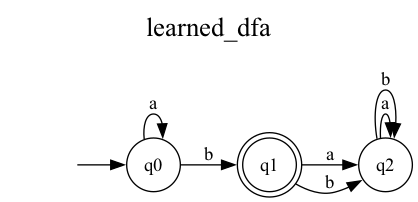


Learned DFA visualized as 'learned_dfa.png'
[DEBUG And.__init__] Initializing And with r1=Star, r2=Char


# Adding State
## State: 1
## Transitions: {}

# Adding State
## State: 1
## Transitions: {}

# Adding State
## State: 1
## Transitions: {}

[DEBUG Star.to_nfa] NFA created: states={0, 1, 2, 3, 4, 5}, final={0}, next_state=6


# Adding State
## State: 1
## Transitions: {}

[DEBUG And.to_nfa] NFA created: states={0, 1, 2, 3, 4, 5, 6, 7}, final={7}, next_state=8


#### Removing Epsilon Transitions

[DEBUG NFA.remove_epsilon] Initialized new NFA: states={0, 1, 2, 3, 4, 5, 6, 7}, final={7}

[DEBUG NFA.remove_epsilon] Marking state 7 as final
[DEBUG NFA.trim_unreachable] Starting BFS from state 0
[DEBUG NFA.trim_unreachable] Visited state 0
[DEBUG NFA.trim_unreachable] Visited state 3
[DEBUG NFA.trim_unreachable] Visited state 7
[DEBUG NFA.trim_unreachable] Removing unreachable state 1
[DEBUG NFA.trim_unreachable] Removing unreachable state 2
[DEBUG NFA.trim_unreachable] Removing unreachable state 4
[DEBUG NFA.trim_unreachable] Removing unreachable state 5
[DEBUG NFA.trim_unreachable] Removing unreachable state 6
[DEBUG NFA.remove_epsilon] states={0, 3, 7}, transitions={0: {'a': {3}, 'b': {7}}, 3: {'a': {3}, 'b': {7}}, 7: {}}
[DEBUG NFA.determinise] Epsilon-free NFA: states={0, 3, 7}, final={7}
[DEBUG NFA.determinise] Subsets for DFA states: [(), (0,), (3,), (7,), (0, 3), (0, 7), (3, 7), (0, 3, 7)]
[DEBUG NFA.determinise] DFA start state: 1


### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 1
[DEBUG DFA.trim_unreachable] Visited state 1
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Queued state 3
[DEBUG DFA.trim_unreachable] Visited state 2
[DEBUG DFA.trim_unreachable] Queued state 3
[DEBUG DFA.trim_unreachable] Visited state 3
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Removing unreachable state 4
[DEBUG DFA.trim_unreachable] Removing unreachable state 5
[DEBUG DFA.trim_unreachable] Removing unreachable state 6
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Final states: {0, 1, 2, 3}
[DEBUG NFA.determinise] Final DFA: states={0, 1, 2, 3}, transitions={0: {'a': 0, 'b': 0}, 1: {'a': 2, 'b': 3}, 2: {'a': 2, 'b': 3}, 3: {'a': 0, 'b': 0}}
Target DFA visualized as 'target_dfa.png'


Converting Hypothesis to DFA with alphabet: ab

[DEBUG Transition.target_state] Getting target state for aseq='ba': q2
[DEBUG Transition.target_state] Getting target state for aseq='ba': q2
[DEBUG Transition.target_state] Getting target state for aseq='ba': q2


Transition: q1 --a--> q2

[DEBUG Transition.target_state] Getting target state for aseq='bb': q2
[DEBUG Transition.target_state] Getting target state for aseq='bb': q2
[DEBUG Transition.target_state] Getting target state for aseq='bb': q2


Transition: q1 --b--> q2

[DEBUG Transition.target_state] Getting target state for aseq='a': q0
[DEBUG Transition.target_state] Getting target state for aseq='a': q0
[DEBUG Transition.target_state] Getting target state for aseq='a': q0


Transition: q0 --a--> q0

[DEBUG Transition.target_state] Getting target state for aseq='b': q1
[DEBUG Transition.target_state] Getting target state for aseq='b': q1
[DEBUG Transition.target_state] Getting target state for aseq='b': q1


Transition: q0 --b--> q1

[DEBUG Transition.target_state] Getting target state for aseq='baa': q2
[DEBUG Transition.target_state] Getting target state for aseq='baa': q2
[DEBUG Transition.target_state] Getting target state for aseq='baa': q2


Transition: q2 --a--> q2

[DEBUG Transition.target_state] Getting target state for aseq='bab': q2
[DEBUG Transition.target_state] Getting target state for aseq='bab': q2
[DEBUG Transition.target_state] Getting target state for aseq='bab': q2


Transition: q2 --b--> q2

[DEBUG DFA.close_with_sink] Adding sink state 4 for alphabet ['a', 'b']


# Adding State
## State: 4
## Transitions: {'a': 4, 'b': 4}

[DEBUG DFA.close_with_sink] Transitions after adding sink: {1: {'a': 2, 'b': 2}, 0: {'a': 0, 'b': 1}, 2: {'a': 2, 'b': 2}, 4: {'a': 4, 'b': 4}}
[DEBUG Hypothesis.to_dfa] DFA after sink: transitions={1: {'a': 2, 'b': 2}, 0: {'a': 0, 'b': 1}, 2: {'a': 2, 'b': 2}, 4: {'a': 4, 'b': 4}}
[DEBUG DFA.is_equivalent] Checking equivalence with another DFA
[DEBUG DFA.complement] Creating complement DFA
[DEBUG DFA.complement] Complement final states: {0, 2, 4}
[DEBUG DFA.intersection] Product states: [(0, 0), (0, 1), (0, 2), (0, 4), (1, 0), (1, 1), (1, 2), (1, 4), (2, 0), (2, 1), (2, 2), (2, 4), (3, 0), (3, 1), (3, 2), (3, 4)]
[DEBUG DFA.intersection] Intersection start state: 4
[DEBUG DFA.intersection] Intersection final states: {12, 14, 15}
[DEBUG DFA.intersection] Transition 0 --a--> 0 (from 0,0)
[DEBUG DFA.intersection] Transition 0 --b--> 1 (from 0,0)
[DEBUG DFA.intersection] Transition 1 --a--> 2 (from 0,1)
[DEBUG DFA.intersection] Transition 1 --b--> 2 (from 0,1)
[DEBUG DFA.intersection] Tra

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 4
[DEBUG DFA.trim_unreachable] Visited state 4
[DEBUG DFA.trim_unreachable] Queued state 8
[DEBUG DFA.trim_unreachable] Queued state 13
[DEBUG DFA.trim_unreachable] Visited state 8
[DEBUG DFA.trim_unreachable] Queued state 13
[DEBUG DFA.trim_unreachable] Visited state 13
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Visited state 2
[DEBUG DFA.trim_unreachable] Removing unreachable state 0
[DEBUG DFA.trim_unreachable] Removing unreachable state 1
[DEBUG DFA.trim_unreachable] Removing unreachable state 3
[DEBUG DFA.trim_unreachable] Removing unreachable state 5
[DEBUG DFA.trim_unreachable] Removing unreachable state 6
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Removing unreachable state 9
[DEBUG DFA.trim_unreachable] Removing unreachable state 10
[DEBUG DFA.trim_unreachable] Removing unreachable state 11
[DEBUG DFA.trim_un

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 4
[DEBUG DFA.trim_unreachable] Visited state 4
[DEBUG DFA.trim_unreachable] Queued state 8
[DEBUG DFA.trim_unreachable] Queued state 13
[DEBUG DFA.trim_unreachable] Visited state 8
[DEBUG DFA.trim_unreachable] Queued state 13
[DEBUG DFA.trim_unreachable] Visited state 13
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Visited state 2
[DEBUG DFA.trim_unreachable] Removing unreachable state 0
[DEBUG DFA.trim_unreachable] Removing unreachable state 1
[DEBUG DFA.trim_unreachable] Removing unreachable state 3
[DEBUG DFA.trim_unreachable] Removing unreachable state 5
[DEBUG DFA.trim_unreachable] Removing unreachable state 6
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Removing unreachable state 9
[DEBUG DFA.trim_unreachable] Removing unreachable state 10
[DEBUG DFA.trim_unreachable] Removing unreachable state 11
[DEBUG DFA.trim_un

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 5
[DEBUG DFA.trim_unreachable] Visited state 5
[DEBUG DFA.trim_unreachable] Queued state 10
[DEBUG DFA.trim_unreachable] Queued state 15
[DEBUG DFA.trim_unreachable] Visited state 10
[DEBUG DFA.trim_unreachable] Queued state 15
[DEBUG DFA.trim_unreachable] Visited state 15
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Removing unreachable state 1
[DEBUG DFA.trim_unreachable] Removing unreachable state 2
[DEBUG DFA.trim_unreachable] Removing unreachable state 3
[DEBUG DFA.trim_unreachable] Removing unreachable state 4
[DEBUG DFA.trim_unreachable] Removing unreachable state 6
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Removing unreachable state 8
[DEBUG DFA.trim_unreachable] Removing unreachable state 9
[DEBUG DFA.trim_unreachable] Removing unreachable state 11
[DEBUG DFA.trim_u

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 5
[DEBUG DFA.trim_unreachable] Visited state 5
[DEBUG DFA.trim_unreachable] Queued state 10
[DEBUG DFA.trim_unreachable] Queued state 15
[DEBUG DFA.trim_unreachable] Visited state 10
[DEBUG DFA.trim_unreachable] Queued state 15
[DEBUG DFA.trim_unreachable] Visited state 15
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Final states: {0, 5, 10, 15}
[DEBUG DFA.is_equivalent] After trimming: states={0, 5, 10, 15}
[DEBUG DFA.is_empty] Queuing transition 5 --a--> 10
[DEBUG DFA.is_empty] Queuing transition 5 --b--> 15
[DEBUG DFA.is_empty] Queuing transition 10 --a--> 10
[DEBUG DFA.is_empty] Queuing transition 10 --b--> 15
[DEBUG DFA.is_empty] Queuing transition 15 --a--> 0
[DEBUG DFA.is_empty] Queuing transition 15 --b--> 0
[DEBUG DFA.is_empty] Queuing transition 0 --a--> 0
[DEBUG DFA.is_empty] Queuing transition 0 --b--> 0
[D

### Equivalence Check: Equivalent

In [422]:
if __name__ == "__main__":
    alphabet = "ab"
    pattern = r"(a|b)*b"

    __builtins__.print(f"Learning language for regex: '{pattern}' over alphabet '{alphabet}'")

    teacher = PerfectTeacher(alphabet, pattern)
    ttt = TTTAlgorithm(teacher, alphabet)
    hypothesis, dtree = ttt.learn()

    display(Markdown("### Learned Hypothesis"))
    hypothesis.print_hypothesis()
    display(Markdown("### Final Discrimination Tree Visualization"))
    visualize_dtree(dtree)

    visualize_dfa(hypothesis, filename="learned_dfa")
    __builtins__.print("\nLearned DFA visualized as 'learned_dfa.png'")

    target_dfa = Regex.parse(pattern).to_nfa().determinise()
    target_dfa.visualize("target_dfa")
    __builtins__.print("Target DFA visualized as 'target_dfa.png'")

    is_equiv, _ = target_dfa.is_equivalent(hypothesis.to_dfa())
    display(Markdown(f"### Equivalence Check: {'Equivalent' if is_equiv else 'Not Equivalent'}"))


### Conclusion
The TTT algorithm represents a significant advancement in the field of active automata learning, offering a more space- and query-efficient alternative to traditional approaches like Angluin’s L* algorithm. By leveraging discrimination trees and refined counterexample analysis, TTT minimizes redundancy and accelerates the learning process, making it especially effective for inferring the input grammars of blackbox programs.

Through this tutorial, we have explored the theoretical foundations of the TTT algorithm, its practical implementation in Python, and its application to real-world grammar inference tasks. The step-by-step walkthrough, combined with visualizations of the learned automata and discrimination trees, demonstrates how TTT can systematically construct a minimal DFA that accurately models the target language.

As software systems grow in complexity and the need for automated analysis increases, algorithms like TTT will play a crucial role in reverse engineering, protocol inference, and automated testing. By understanding and applying these techniques, practitioners and researchers can gain deeper insights into unknown systems and develop more robust tools for software analysis.

### References

- https://stackoverflow.com/questions/34012886/print-binary-tree-level-by-level-in-python
- Isberner, M., Howar, F., & Steffen, B. (2014). The TTT Algorithm: A Redundancy-Free Approach to Active Automata Learning. Springer, Cham. https://doi.org/10.1007/978-3-319-11164-3_26
- Angluin, D. (1987). Learning Regular Sets from Queries and Counterexamples. Information and Computation, 75(2), 87–106.